# Predictive Maintenance with Specialized GANs for Failure-Specific Oversampling

## Thesis Objective
This notebook is a core component of a thesis investigating advanced methods for handling class imbalance in predictive maintenance. The primary objective is to evaluate a specialized multi-GAN architecture against traditional sampling techniques. Instead of a single generative model for all failures, we train multiple Generative Adversarial Networks (GANs), where each GAN is an expert on a specific failure type (e.g., Overstrain, Power Failure). This approach is hypothesized to generate more realistic and useful synthetic data by capturing the unique data signatures of each failure mode.

We will compare the performance of Random Forest and SVM classifiers trained on data augmented by this specialized GAN approach against a baseline and standard methods like SMOTE and Random Undersampling.

The dataset used is the AI4I 2020 Predictive Maintenance Dataset, which is known for its severe class imbalance (3.4% failure rate) and its mixture of five distinct failure modes, including Heat Dissipation and Power Failure [1]. The generative model is based on the Conditional Tabular GAN (CTGAN) architecture, which utilizes mode-specific normalization and conditional generation to effectively model complex tabular data distributions [2].
[1]:"https://www.sciencedirect.com/science/article/pii/S2949863524000219".
[2]:"https://www.researchgate.net/publication/344468956_Tabular_GANs_for_Uneven_Distribution".

## Notebook Structure
1.  Setup: Import libraries and provide environment setup guidance.
2.  GPU Check: Verify GPU availability for PyTorch, which accelerates TabGAN training.
3.  Load & Preprocess Data: Load, clean, and perform feature engineering on the predictive_maintenance.csv dataset.
4.  Exploratory Data Analysis (EDA): Analyze data characteristics, with a focus on the distinct signatures of different failure types.
5.  Data Splitting: Split data into Train, Validation, and Test sets to ensure robust evaluation and prevent data leakage.
6.  Modeling Scenarios:
    *   Scenario 1: Baseline (No Resampling)
    *   Scenario 2: Random Undersampling
    *   Scenario 3: SMOTE Oversampling
    *   Scenario 4: Specialized Multi-GAN Oversampling - This is the core of the new approach.
7.  Hyperparameter Tuning & Model Training:
    *   For the Multi-GAN scenario, a hyperparameter search is conducted to find the optimal GAN parameters, evaluating against the validation set.
    *   For all scenarios, GridSearchCV is used to tune the final classifiers (Random Forest & SVM).
8.  Evaluation: Assess all final models on the unseen test set using metrics appropriate for imbalanced data (F1, ROC-AUC, Recall, Precision).
9.  Results Comparison: Compile and visualize results to compare the effectiveness of each sampling strategy.
10. Conclusion: Discuss the findings, focusing on the performance of the specialized multi-GAN architecture.

## 0. Notebook Timer & Performance Controls

In [43]:
# === Notebook Timer — START ===
import time, datetime, atexit

NB_START_TS = datetime.datetime.now()
NB_START = time.perf_counter()

def _report_total_runtime(prefix="Notebook"):
    elapsed = time.perf_counter() - NB_START
    h, rem = divmod(elapsed, 3600)
    m, s = divmod(rem, 60)
    print(f"\n=== {prefix} runtime ===")
    print(f"Started : {NB_START_TS:%Y-%m-%d %H:%M:%S}")
    print(f"Elapsed : {int(h)}h {int(m)}m {s:.1f}s")

# Optional safety: if the kernel shuts down/crashes, you'll still get a report
atexit.register(_report_total_runtime, prefix="Kernel session")
# === /Notebook Timer — START ===

# ==== Threading & determinism ====
import os, random
import numpy as np
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["PYTHONHASHSEED"] = "42"

CPU_COUNT = os.cpu_count() or 4
N_JOBS = max(1, CPU_COUNT - 2)   # reuse this instead of -1 everywhere

random.seed(42)
np.random.seed(42)


## 1. Setup

This section imports necessary libraries and provides instructions for setting up the Python environment, including optional GPU acceleration via CUDA for TabGAN.

In [44]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
import time # To measure execution time
import logging # To manage library logging

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    PrecisionRecallDisplay,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# Imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# Pipeline compatible with imblearn transformers
from imblearn.pipeline import Pipeline as ImbPipeline

# TabGAN (for GAN Oversampling)
try:
    from tabgan.sampler import GANGenerator
    import torch # TabGAN uses PyTorch
    GAN_AVAILABLE = True
    PYTORCH_AVAILABLE = True
except ImportError as e:
    print(f"Warning: TabGAN or PyTorch could not be imported. GAN scenario will be skipped. Error: {e}")
    print("Try installing with: pip install tabgan torch torchvision torchaudio")
    GANGenerator = None # Define as None if import fails
    GAN_AVAILABLE = False
    PYTORCH_AVAILABLE = False

# Threading
import joblib
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

print("Libraries imported.")
if PYTORCH_AVAILABLE:
    print(f"PyTorch Version: {torch.__version__}")
if GAN_AVAILABLE:
    print("TabGAN (for GAN Oversampling) is available.")
else:
    print("TabGAN could not be loaded. GAN scenario will be skipped.")


Libraries imported.
PyTorch Version: 2.5.1
TabGAN (for GAN Oversampling) is available.


## 2. GPU Check

This cell checks if a CUDA-enabled GPU is available for PyTorch (used by TabGAN).

In [45]:
gpu_available_for_tabgan = False
if PYTORCH_AVAILABLE:
    if torch.cuda.is_available():
        print(f"SUCCESS: PyTorch detected CUDA-enabled GPU: {torch.cuda.get_device_name(0)}")
        print("TabGAN will attempt to use the GPU if available.")
        gpu_available_for_tabgan = True
    else:
        print("INFO: PyTorch did not detect a CUDA-enabled GPU. TabGAN will run on CPU.")
else:
    print("INFO: PyTorch not available, cannot check for GPU for TabGAN.")

try:
    import torch
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    # Reproducible kernels
    if hasattr(torch.backends, "cudnn"):
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    try:
        torch.use_deterministic_algorithms(True, warn_only=True)
    except Exception:
        pass
    torch.set_num_threads(2)  # don't hog all cores
except Exception:
    pass


SUCCESS: PyTorch detected CUDA-enabled GPU: NVIDIA GeForce GTX 1060 with Max-Q Design
TabGAN will attempt to use the GPU if available.


## 3. Load & Preprocess Data

Load the dataset, perform feature engineering by converting temperature units and creating a difference feature, and sanitize column names.

**Rationale for Feature Engineering**

Two key feature engineering steps were performed based on insights from the AI4I 2020 dataset paper:

1. **Temperature Conversion (K to °C):** While models can process data on any scale, converting temperatures to Celsius enhances the interpretability of the Exploratory Data Analysis (EDA) and any subsequent model explanation steps.

2. **Creation of Temperature_difference_C:** The most common type of failure (as we will see later) is Heat Dissipation Failure. This means that the heat created during the milling process is not dissipated properly, resulting in heat accumulating at the mill tip. This thought is validated be the dataset paper, which states that Heat Dissipation Failure happens when the air and process temperature difference is small and RPM takes a relatively small value. This means that in order to predict this type of failure, we will need a feature that represents the difference between process temperature and air temperature.

In [46]:
# Load the dataset
try:
    df = pd.read_csv('predictive_maintenance.csv')
    print("Dataset loaded successfully.")
    print(f"Original dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: predictive_maintenance.csv not found. Please ensure the file is in the same directory as the notebook.")
    df = None

if df is not None:
    # Drop unnecessary columns
    df = df.drop(['UDI', 'Product ID'], axis=1)

    # 1. Convert temperatures from Kelvin to Celsius for better interpretability
    df['Air temperature [K]'] = df['Air temperature [K]'] - 273.15
    df['Process temperature [K]'] = df['Process temperature [K]'] - 273.15
    df.rename(columns={'Air temperature [K]': 'Air_temperature_C', 'Process temperature [K]': 'Process_temperature_C'}, inplace=True)
    print("\nConverted temperature units from Kelvin to Celsius.")

    # 2. Create the temperature difference feature
    df['Temperature_difference_C'] = df['Process_temperature_C'] - df['Air_temperature_C']
    print("Created 'Temperature_difference_C' feature.")

    # --- Data Cleaning: Sanitize All Column Names ---
    print("\nOriginal column names:\n", df.columns.tolist())
    clean_cols = {col: col.replace('[', '').replace(']', '').replace(' ', '').replace('(', '').replace(')', '') for col in df.columns}
    df.rename(columns=clean_cols, inplace=True)
    print("\nCleaned column names:\n", df.columns.tolist())

    # --- Update feature lists with new and cleaned names ---
    numerical_features = ['Air_temperature_C', 'Process_temperature_C', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Temperature_difference_C']
    # Cast numerics once
    df[numerical_features] = df[numerical_features].astype(np.float32)

    categorical_features = ['Type']
    print("\nUpdated feature lists defined.")

    print("\nFirst 5 rows of the preprocessed dataset:")
    display(df.head())

    print("\nDataset Information after preprocessing:")
    df.info()

    print("\nDescriptive Statistics after preprocessing:")
    display(df.describe())

Dataset loaded successfully.
Original dataset shape: (10000, 10)

Converted temperature units from Kelvin to Celsius.
Created 'Temperature_difference_C' feature.

Original column names:
 ['Type', 'Air_temperature_C', 'Process_temperature_C', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type', 'Temperature_difference_C']

Cleaned column names:
 ['Type', 'Air_temperature_C', 'Process_temperature_C', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Target', 'FailureType', 'Temperature_difference_C']

Updated feature lists defined.

First 5 rows of the preprocessed dataset:


,Type,Air_temperature_C,Process_temperature_C,Rotationalspeedrpm,TorqueNm,Toolwearmin,Target,FailureType,Temperature_difference_C
0,M,24.950001,35.450001,1551.0,42.799999,0.0,0,No Failure,10.5
1,L,25.049999,35.549999,1408.0,46.299999,3.0,0,No Failure,10.5
2,L,24.950001,35.349998,1498.0,49.400002,5.0,0,No Failure,10.4
3,L,25.049999,35.450001,1433.0,39.500000,7.0,0,No Failure,10.4
4,L,25.049999,35.549999,1408.0,40.000000,9.0,0,No Failure,10.5



Dataset Information after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      10000 non-null  object 
 1   Air_temperature_C         10000 non-null  float32
 2   Process_temperature_C     10000 non-null  float32
 3   Rotationalspeedrpm        10000 non-null  float32
 4   TorqueNm                  10000 non-null  float32
 5   Toolwearmin               10000 non-null  float32
 6   Target                    10000 non-null  int64  
 7   FailureType               10000 non-null  object 
 8   Temperature_difference_C  10000 non-null  float32
dtypes: float32(6), int64(1), object(2)
memory usage: 468.9+ KB

Descriptive Statistics after preprocessing:


,Air_temperature_C,Process_temperature_C,Rotationalspeedrpm,TorqueNm,Toolwearmin,Target,Temperature_difference_C
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,26.854931,36.855560,1538.776123,39.986908,107.950996,0.033900,10.000630
std,2.000259,1.483734,179.284103,9.968934,63.654148,0.180981,1.001094
min,22.150000,32.549999,1168.000000,3.800000,0.000000,0.000000,7.600000
25%,25.150000,35.650002,1423.000000,33.200001,53.000000,0.000000,9.300000
50%,26.950001,36.950001,1503.000000,40.099998,108.000000,0.000000,9.800000
75%,28.350000,37.950001,1612.000000,46.799999,162.000000,0.000000,11.000000
max,31.350000,40.650002,2886.000000,76.599998,253.000000,1.000000,12.100000


## 4. Exploratory Data Analysis (EDA)

In this section, we conduct an Exploratory Data Analysis to achieve three primary goals:

1. **Quantify Class Imbalance:** To confirm the severity of the imbalance in both the overall target and within the specific failure types.

2. **Identify Predictive Features:** To visually inspect which features show different distributions for failure vs. non-failure cases.

3. **Justify the Multi-GAN Approach:** To analyze the feature distributions for each specific failure type (e.g., how does the *TorqueNm* distribution for 'Power Failure' differ from that of 'Overstrain Failure'?). This analysis is critical for validating the core hypothesis that each failure mode has a unique data signature.

### 4.1 Target Variable & Failure Type Analysis

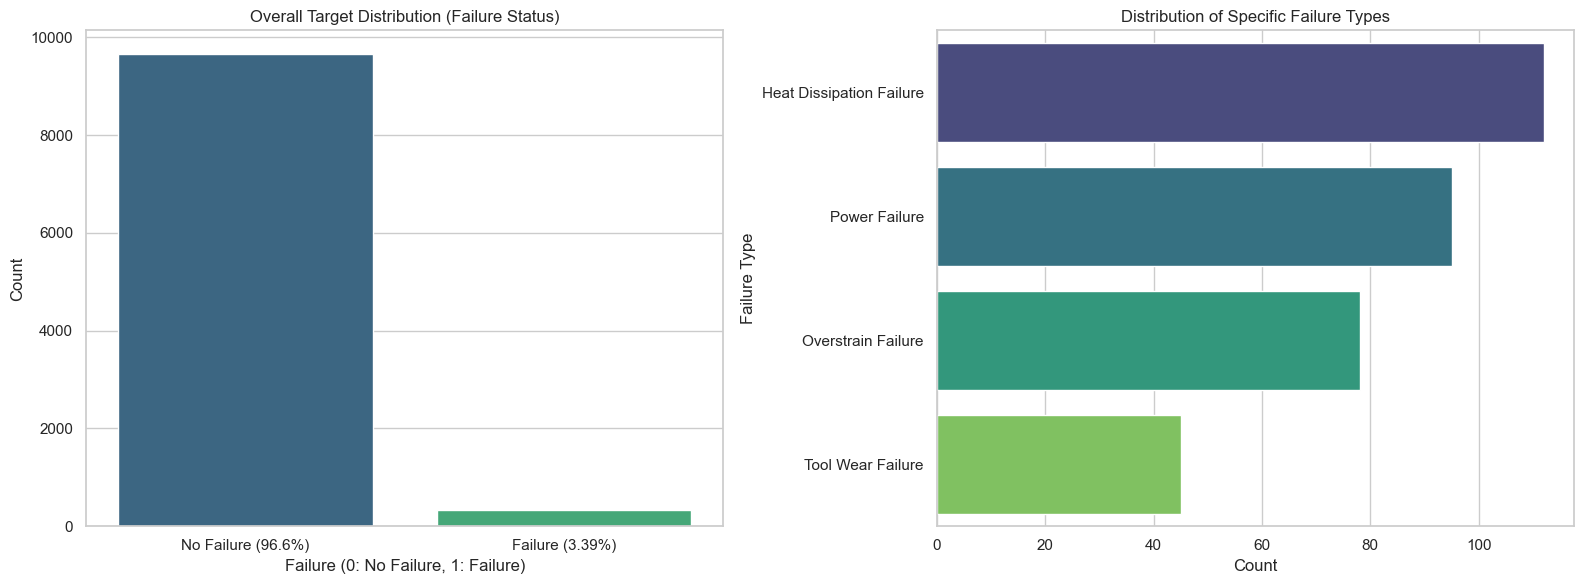

Failure Type Counts:
FailureType
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Name: count, dtype: int64


In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall Target Distribution
target_counts = df['Target'].value_counts()
sns.countplot(x='Target', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Overall Target Distribution (Failure Status)')
axes[0].set_xlabel('Failure (0: No Failure, 1: Failure)')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1], ['No Failure (96.6%)', f'Failure ({target_counts[1]/len(df):.2%})'])

# Plot 2: Specific Failure Type Distribution
failure_df = df[df['Target'] == 1]
# Use the cleaned column name 'FailureType'
failure_type_counts = failure_df['FailureType'].value_counts()
failure_type_counts = failure_type_counts[failure_type_counts.index != 'No Failure']
# Use the cleaned column name 'FailureType' for the y-axis
sns.countplot(y='FailureType', data=failure_df[failure_df['FailureType'] != 'No Failure'], order=failure_type_counts.index, palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Specific Failure Types')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Failure Type')

plt.tight_layout()
plt.show()



print("Failure Type Counts:")
print(failure_type_counts)

## 4.2 The 'Type' Feature

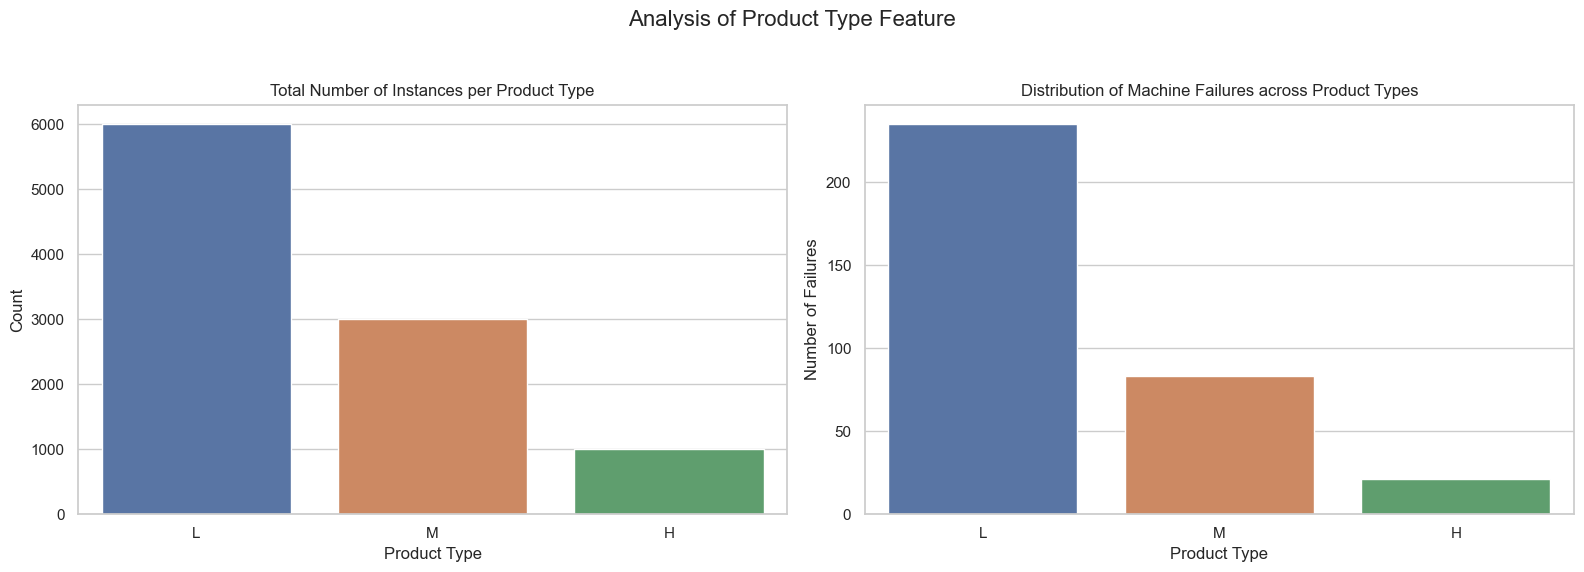

In [48]:
# Set up the figure for two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analysis of Product Type Feature', fontsize=16)

# --- Plot 1: Count of each Product Type ---
sns.countplot(ax=axes[0], x='Type', data=df, order=['L', 'M', 'H'])
axes[0].set_title('Total Number of Instances per Product Type')
axes[0].set_xlabel('Product Type')
axes[0].set_ylabel('Count')

# --- Plot 2: Distribution of Failures across Product Types ---
# Filter the dataframe for only instances where a failure occurred
failures_df = df[df['Target'] == 1]
sns.countplot(ax=axes[1], x='Type', data=failures_df, order=['L', 'M', 'H'])
axes[1].set_title('Distribution of Machine Failures across Product Types')
axes[1].set_xlabel('Product Type')
axes[1].set_ylabel('Number of Failures')

# Display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.3 Feature Distributions and Relationships

Numerical Feature Distributions by Failure Status:


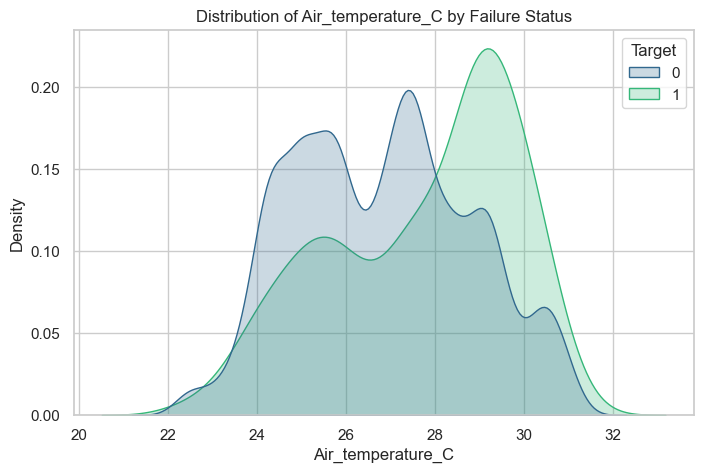

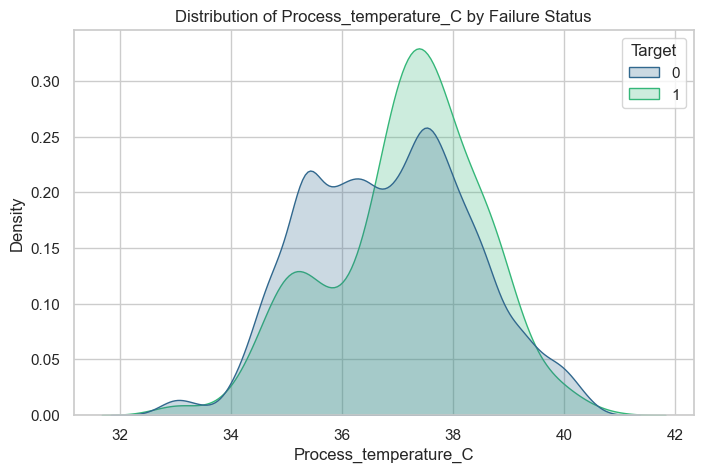

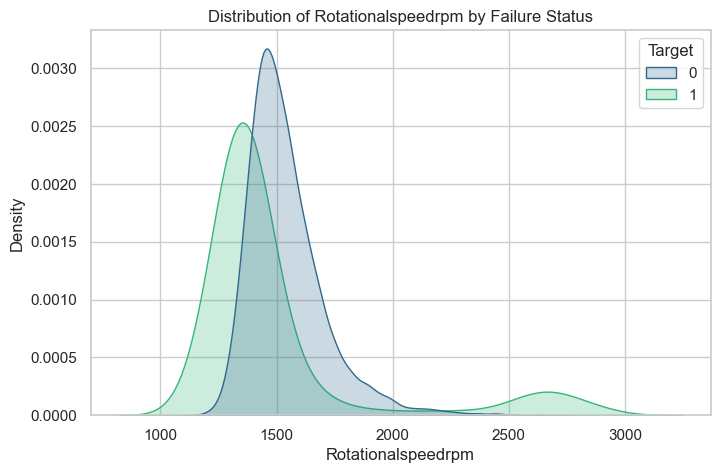

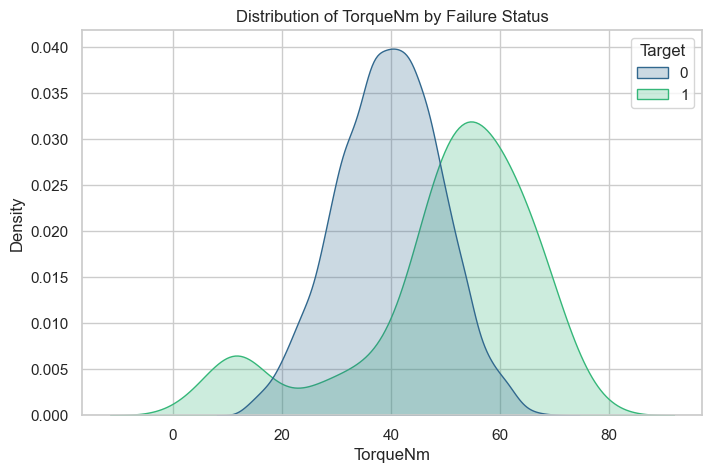

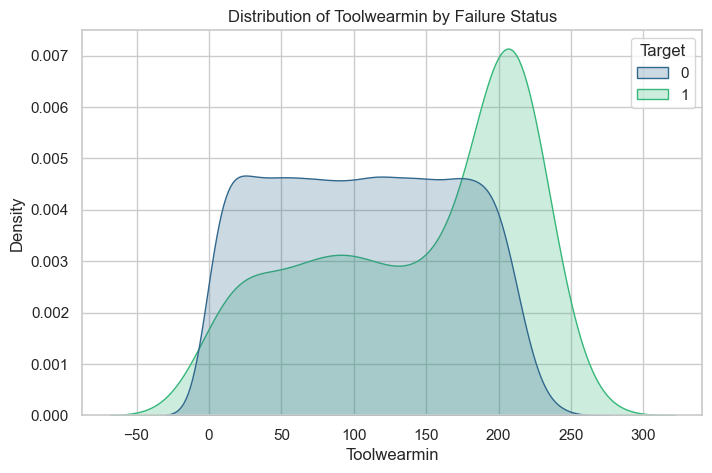

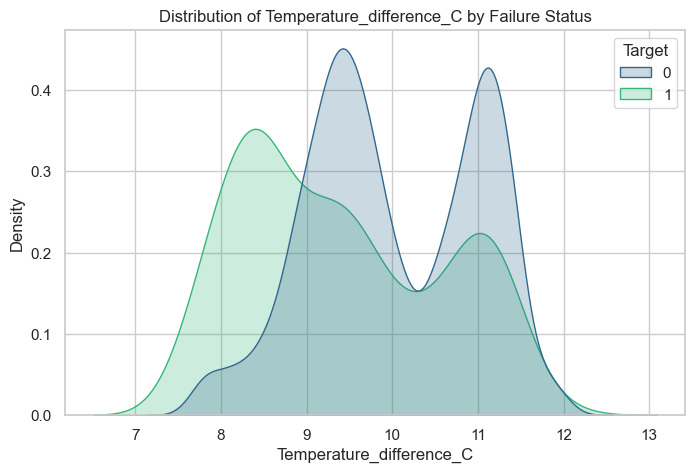

In [49]:
# Plot distributions grouped by Target variable
print("Numerical Feature Distributions by Failure Status:")
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=col, hue='Target', fill=True, common_norm=False, palette='viridis')
    plt.title(f'Distribution of {col} by Failure Status')
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(handles) == 2:
        plt.legend(handles, ['No Failure (0)', 'Failure (1)'], title='Failure Status')
    plt.show()

### 4.4 Correlation Analysis

Correlation Matrix:


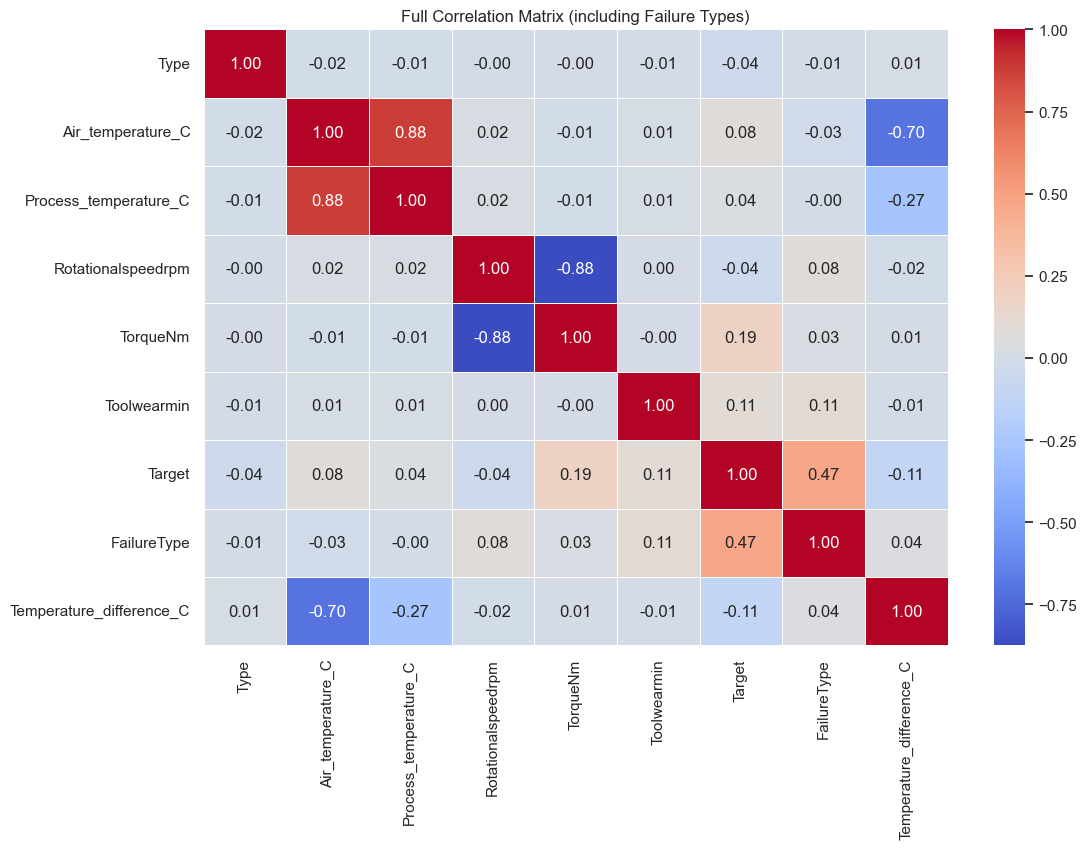

In [50]:
# Create a copy for correlation analysis
df_corr = df.copy()

# Define the explicit order for the 'Type' column
type_order = ['L', 'M', 'H']

# Apply the ordered categorical conversion and get the codes
df_corr['Type'] = df_corr['Type'].astype('category').cat.set_categories(type_order, ordered=True).cat.codes

# Use the cleaned column name 'FailureType'
df_corr['FailureType'] = df_corr['FailureType'].astype('category').cat.codes

print("Correlation Matrix:")
correlation_matrix = df_corr.corr() 

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Full Correlation Matrix (including Failure Types)')
plt.show()

## 5. Data Splitting & Final Preprocessing Setup

We will define the ColumnTransformer for consistent scaling and encoding. Crucially, we split the data into Training (70%), Validation (15%), and Test (15%) sets. The validation set is essential for tuning the GAN hyperparameters without leaking information from the final test set.

In [51]:
# Define features (X) and target (y)
# We keep 'Failure_Type' in X for now to identify subsets for GAN training
X = df.drop(['Target'], axis=1)
y = df['Target']

# --- Train-Validation-Test Split ---
# First split: 70% for training, 30% for a temporary set (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Split the 30% temp set into 15% validation and 15% test (50/50 split)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("--- Data Split Complete ---")
print(f"Training set shape: {X_train.shape}, Target distribution:\n{y_train.value_counts(normalize=True)}\n")
print(f"Validation set shape: {X_val.shape}, Target distribution:\n{y_val.value_counts(normalize=True)}\n")
print(f"Test set shape: {X_test.shape}, Target distribution:\n{y_test.value_counts(normalize=True)}\n")

# Now we can drop 'FailureType' from the feature sets used for classification
X_train_model = X_train.drop('FailureType', axis=1)
X_val_model = X_val.drop('FailureType', axis=1)
X_test_model = X_test.drop('FailureType', axis=1)

# Define the explicit order for the 'Type' column, which is our only categorical feature
type_order = ['L', 'M', 'H']

# Define the preprocessor using the final feature lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OrdinalEncoder(categories=[type_order]), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)(**not any**)
)

# Display the preprocessor to verify
preprocessor
print("Preprocessor (ColumnTransformer) configured.")

--- Data Split Complete ---
Training set shape: (7000, 8), Target distribution:
Target
0    0.966143
1    0.033857
Name: proportion, dtype: float64

Validation set shape: (1500, 8), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Test set shape: (1500, 8), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Preprocessor (ColumnTransformer) configured.


## 6. Modeling Setup

Define models, hyperparameter grids, metrics, and the cross-validation strategy.

Throughout this project, we are going to use a very shallow parameter grid in order for the run time of the hyper-parameter optimization trials for scenario 4 not to grow extremely large, given my hardware limitations.

In [52]:
# Define Models
# Baseline uses 'balanced'; all other scenarios use None (to avoid double weighting after resampling)
rf_model_balanced     = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=N_JOBS)
svm_model_balanced    = SVC(random_state=42, probability=True, class_weight='balanced', cache_size=500)

rf_model_unweighted   = RandomForestClassifier(random_state=42, class_weight=None,     n_jobs=N_JOBS)
svm_model_unweighted  = SVC(random_state=42, probability=True, class_weight=None,     cache_size=500)

# Define Hyperparameter Grids for final classifiers
param_grid_rf = {
    'model__n_estimators': [200],
    'model__max_depth': [10, 20],
    'model__min_samples_leaf': [1, 3]
}

param_grid_svm = {
    'model__C': [1, 10],
    'model__gamma': ['scale', 0.1]
}

# Store results and best model info
results = {}
best_models_info = {}

# Define Stratified K-Fold for cross-validation
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring_multi = {'ap': 'average_precision', 'roc': 'roc_auc'}

print("Models, hyperparameter grids, and evaluation setup complete.")

Models, hyperparameter grids, and evaluation setup complete.


In [53]:
def evaluate_model(model_name, scenario_name, model, X_test_eval, y_test_eval, results_dict):
    """Calculates and stores evaluation metrics for a given model and test set."""
    print(f"--- Evaluating {model_name} ({scenario_name}) ---")
    start_time = time.time()
    y_pred = model.predict(X_test_eval)
    y_prob = model.predict_proba(X_test_eval)[:, 1]
    end_time = time.time()
    inference_time = end_time - start_time

    # NEW: PRC-AUC (Average Precision)
    pr_auc = average_precision_score(y_test_eval, y_prob)

    metrics = {
        'Accuracy': accuracy_score(y_test_eval, y_pred),
        'Precision': precision_score(y_test_eval, y_pred, zero_division=0),
        'Recall': recall_score(y_test_eval, y_pred),
        'F1': f1_score(y_test_eval, y_pred),
        'ROC_AUC': roc_auc_score(y_test_eval, y_prob),
        # NEW ↓
        'PR_AUC': pr_auc
    }

    if scenario_name not in results_dict:
        results_dict[scenario_name] = {}
    results_dict[scenario_name][model_name] = metrics

    print(f"Inference Time: {inference_time:.2f} seconds")
    print(classification_report(y_test_eval, y_pred, zero_division=0))
    print(f"ROC AUC Score: {metrics['ROC_AUC']:.4f}")
    # NEW ↓
    print(f"PR AUC (Average Precision): {metrics['PR_AUC']:.4f}")
    print("-" * 60)

    # Plot Confusion Matrix, ROC, and PR curves side-by-side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'Evaluation for {model_name} ({scenario_name})', fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_test_eval, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues, ax=ax1)
    ax1.set_title('Confusion Matrix')

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test_eval, y_prob, ax=ax2, name=model_name)
    ax2.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')
    ax2.set_title('ROC Curve')
    ax2.legend()

    # NEW: Precision-Recall Curve (annotate AP)
    PrecisionRecallDisplay.from_predictions(
        y_test_eval, y_prob, ax=ax3, name=f"{model_name} (AP={pr_auc:.3f})"
    )
    ax3.set_title('Precision–Recall Curve')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return metrics


## 7. Modeling Scenarios

We will now implement the four scenarios. Note: Resampling techniques are always applied only to the training data to prevent data leakage.

Across all scenarios, the underlying classifiers (*RandomForestClassifier* and *SVC*) are initialized with the "*class_weight='balanced'*" parameter. This setting automatically adjusts the weight of each sample in the model's loss function, giving more importance to samples from the under-represented minority class. This serves as a simple, built-in mechanism to mitigate imbalance and ensures that even our baseline model is not entirely naive to the class distribution problem.

### Scenario 1: Baseline (No Resampling)

--- Scenario 1: Baseline (No Resampling) ---

Training Random Forest (Baseline)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
--- Evaluating Random Forest (Baseline) ---
Inference Time: 0.15 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       1.00      0.59      0.74        51

    accuracy                           0.99      1500
   macro avg       0.99      0.79      0.87      1500
weighted avg       0.99      0.99      0.98      1500

ROC AUC Score: 0.9799
PR AUC (Average Precision): 0.8358
------------------------------------------------------------


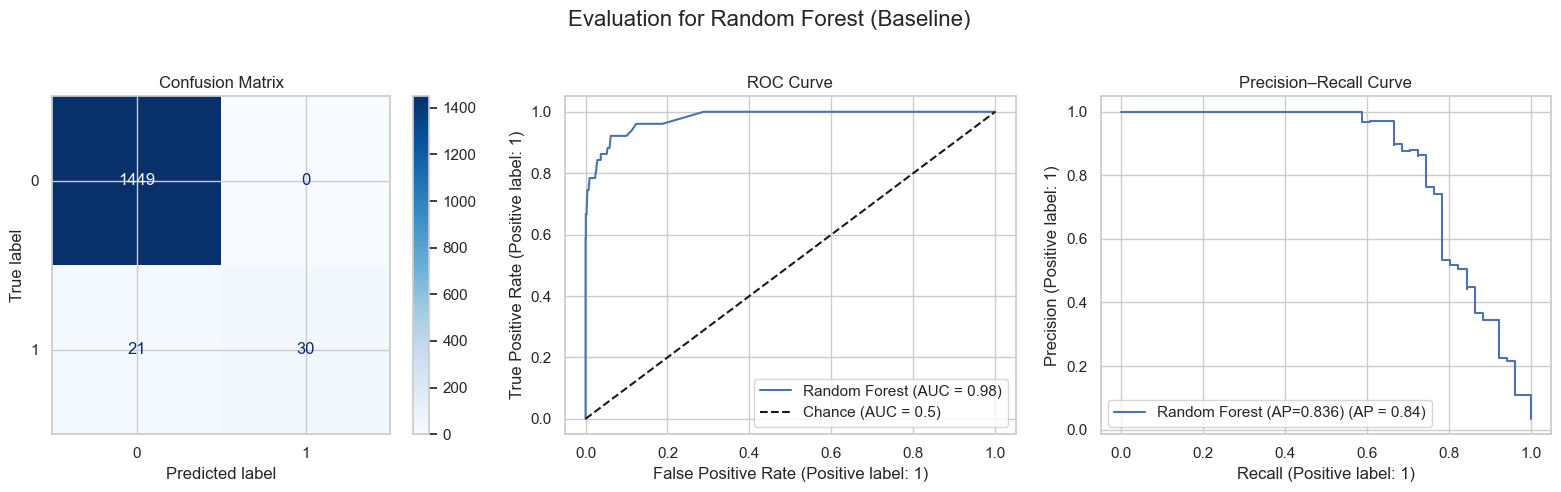


Training SVM (Baseline)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
--- Evaluating SVM (Baseline) ---
Inference Time: 0.43 seconds
              precision    recall  f1-score   support

           0       1.00      0.92      0.95      1449
           1       0.28      0.94      0.43        51

    accuracy                           0.92      1500
   macro avg       0.64      0.93      0.69      1500
weighted avg       0.97      0.92      0.94      1500

ROC AUC Score: 0.9766
PR AUC (Average Precision): 0.7163
------------------------------------------------------------


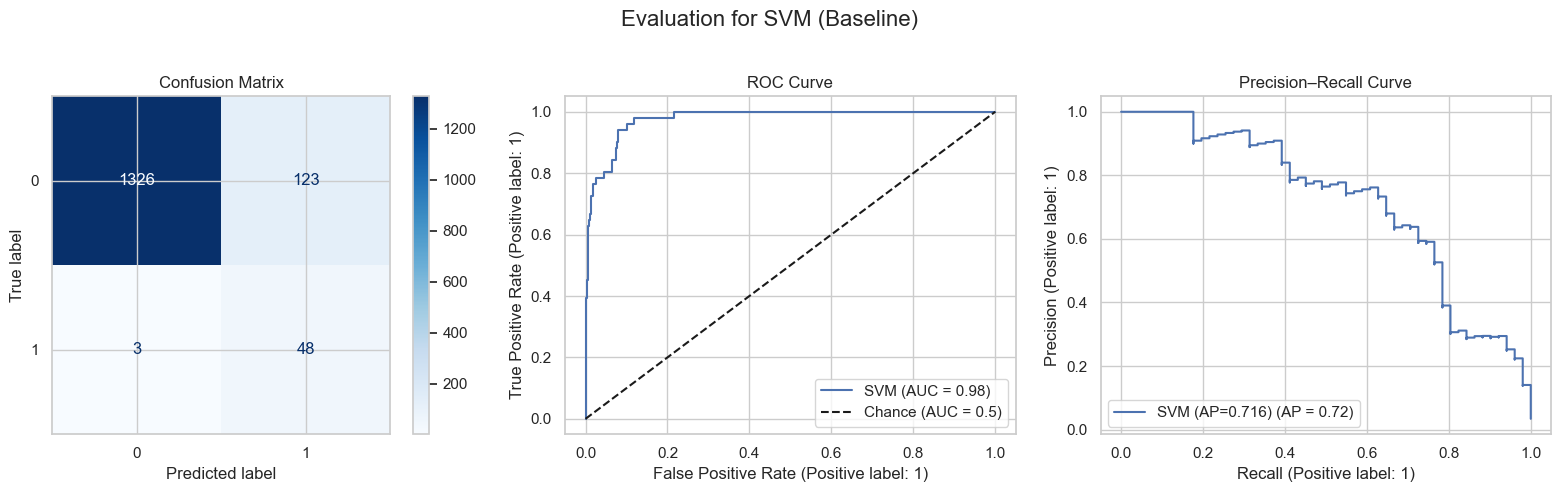

{'Accuracy': 0.916,
 'Precision': 0.2807017543859649,
 'Recall': 0.9411764705882353,
 'F1': 0.4324324324324324,
 'ROC_AUC': 0.9766437976156646,
 'PR_AUC': 0.716275025198673}

In [54]:
print("--- Scenario 1: Baseline (No Resampling) ---")
scenario = 'Baseline'
best_models_info[scenario] = {}

# --- Random Forest ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_base = Pipeline([('preprocessor', preprocessor), ('model', rf_model_balanced)])
grid_search_rf_base = GridSearchCV(pipeline_rf_base, param_grid_rf, cv=cv_stratified, scoring=scoring_multi, refit='ap', n_jobs=N_JOBS, verbose=1)
grid_search_rf_base.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_base.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_base.best_estimator_, X_test_model, y_test, results)

# --- SVM ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_base = Pipeline([('preprocessor', preprocessor), ('model', svm_model_balanced)])
grid_search_svm_base = GridSearchCV(pipeline_svm_base, param_grid_svm, cv=cv_stratified, scoring=scoring_multi, refit='ap', n_jobs=N_JOBS, verbose=1)
grid_search_svm_base.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_base.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_base.best_estimator_, X_test_model, y_test, results)

### Scenario 2: Random Undersampling (RUS)


--- Scenario 2: Random Undersampling (RUS) ---

Training Random Forest (Random Undersampling)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
--- Evaluating Random Forest (Random Undersampling) ---
Inference Time: 0.16 seconds
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1449
           1       0.22      0.92      0.35        51

    accuracy                           0.88      1500
   macro avg       0.61      0.90      0.64      1500
weighted avg       0.97      0.88      0.92      1500

ROC AUC Score: 0.9680
PR AUC (Average Precision): 0.7249
------------------------------------------------------------


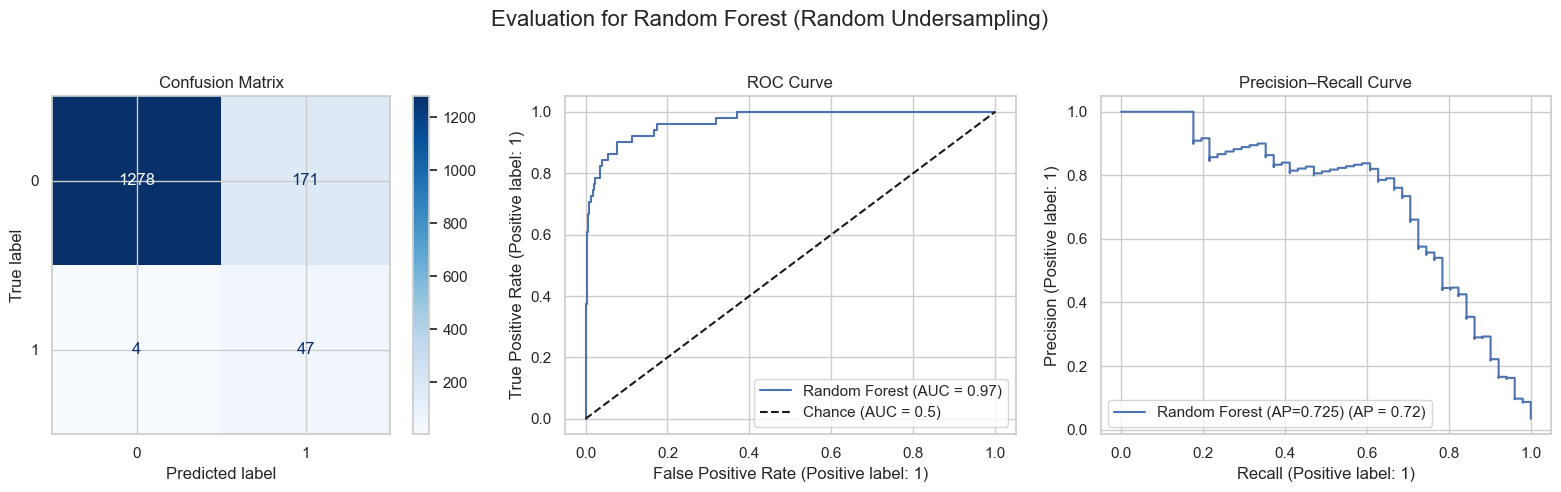


Training SVM (Random Undersampling)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
--- Evaluating SVM (Random Undersampling) ---
Inference Time: 0.05 seconds
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1449
           1       0.22      0.90      0.36        51

    accuracy                           0.89      1500
   macro avg       0.61      0.90      0.65      1500
weighted avg       0.97      0.89      0.92      1500

ROC AUC Score: 0.9610
PR AUC (Average Precision): 0.5735
------------------------------------------------------------


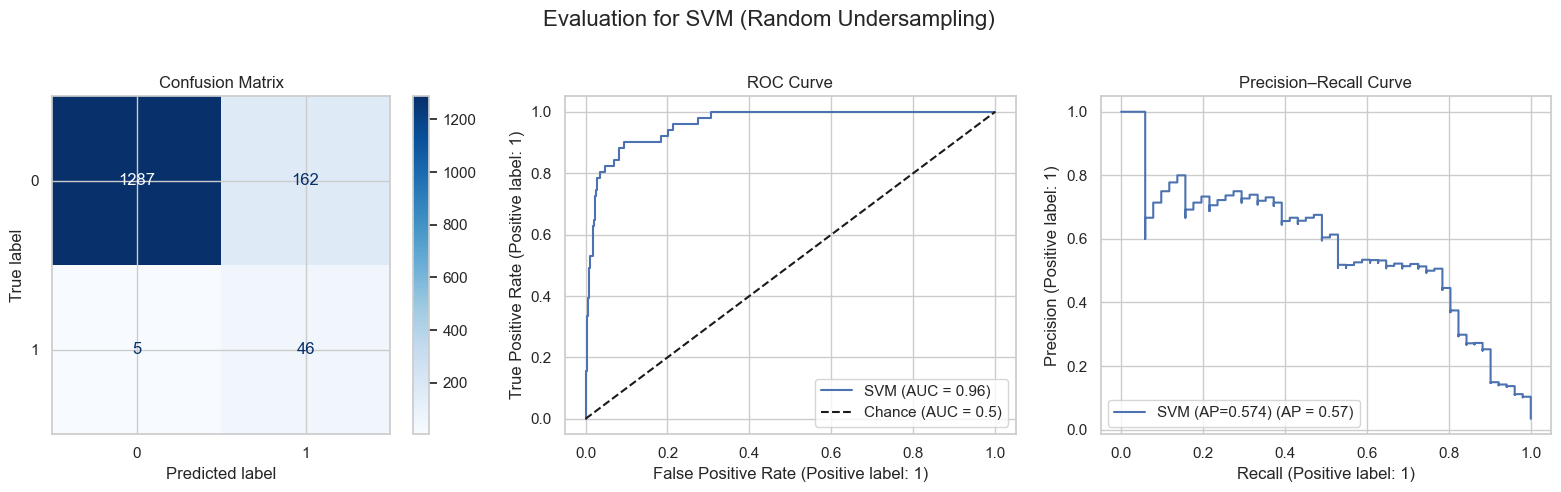

{'Accuracy': 0.8886666666666667,
 'Precision': 0.22115384615384615,
 'Recall': 0.9019607843137255,
 'F1': 0.35521235521235517,
 'ROC_AUC': 0.9610143574337948,
 'PR_AUC': 0.5735450827966095}

In [55]:
print("\n--- Scenario 2: Random Undersampling (RUS) ---")
scenario = 'Random Undersampling'
best_models_info[scenario] = {}
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# --- Random Forest with RUS ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_rus = ImbPipeline([('preprocessor', preprocessor), ('sampler', rus), ('model', rf_model_unweighted)])
grid_search_rf_rus = GridSearchCV(pipeline_rf_rus, param_grid_rf, cv=cv_stratified, scoring=scoring_multi, refit='ap', n_jobs=N_JOBS, verbose=1)
grid_search_rf_rus.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_rus.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_rus.best_estimator_, X_test_model, y_test, results)

# --- SVM with RUS ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_rus = ImbPipeline([('preprocessor', preprocessor), ('sampler', rus), ('model', svm_model_unweighted)])
grid_search_svm_rus = GridSearchCV(pipeline_svm_rus, param_grid_svm, cv=cv_stratified, scoring=scoring_multi, refit='ap', n_jobs=N_JOBS, verbose=1)
grid_search_svm_rus.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_rus.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_rus.best_estimator_, X_test_model, y_test, results)

### Scenario 3: SMOTE Oversampling


--- Scenario 3: SMOTE Oversampling ---

Training Random Forest (SMOTE Oversampling)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
--- Evaluating Random Forest (SMOTE Oversampling) ---
Inference Time: 0.14 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1449
           1       0.53      0.78      0.63        51

    accuracy                           0.97      1500
   macro avg       0.76      0.88      0.81      1500
weighted avg       0.98      0.97      0.97      1500

ROC AUC Score: 0.9775
PR AUC (Average Precision): 0.7522
------------------------------------------------------------


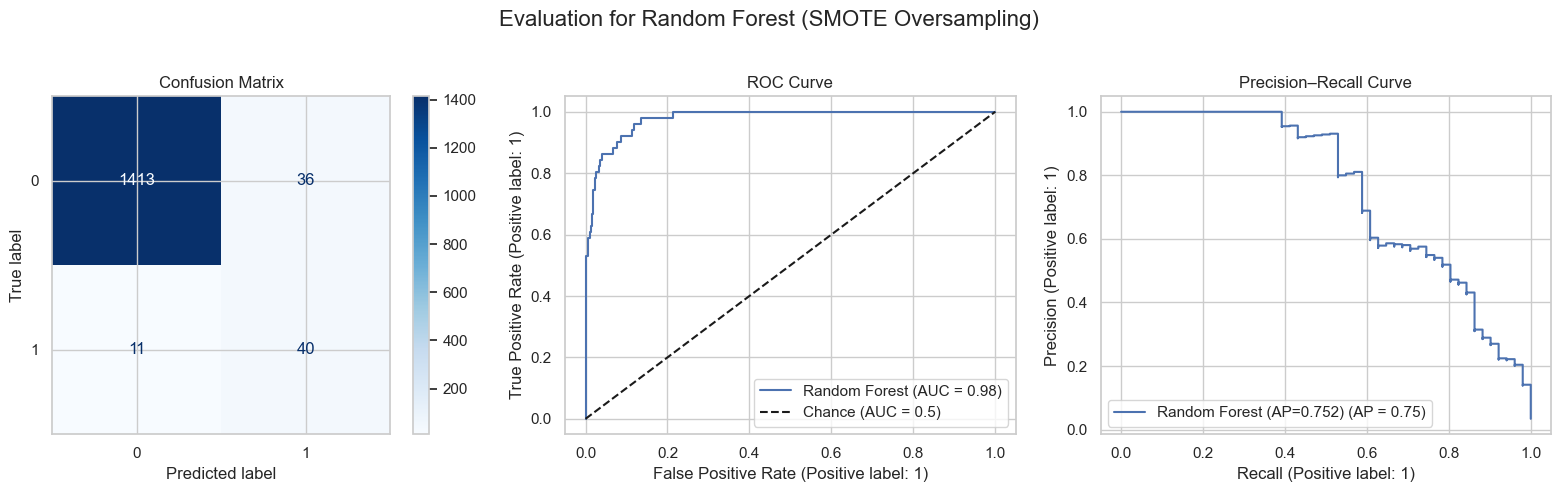


Training SVM (SMOTE Oversampling)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
--- Evaluating SVM (SMOTE Oversampling) ---
Inference Time: 0.70 seconds
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1449
           1       0.27      0.86      0.41        51

    accuracy                           0.92      1500
   macro avg       0.63      0.89      0.68      1500
weighted avg       0.97      0.92      0.94      1500

ROC AUC Score: 0.9741
PR AUC (Average Precision): 0.7328
------------------------------------------------------------


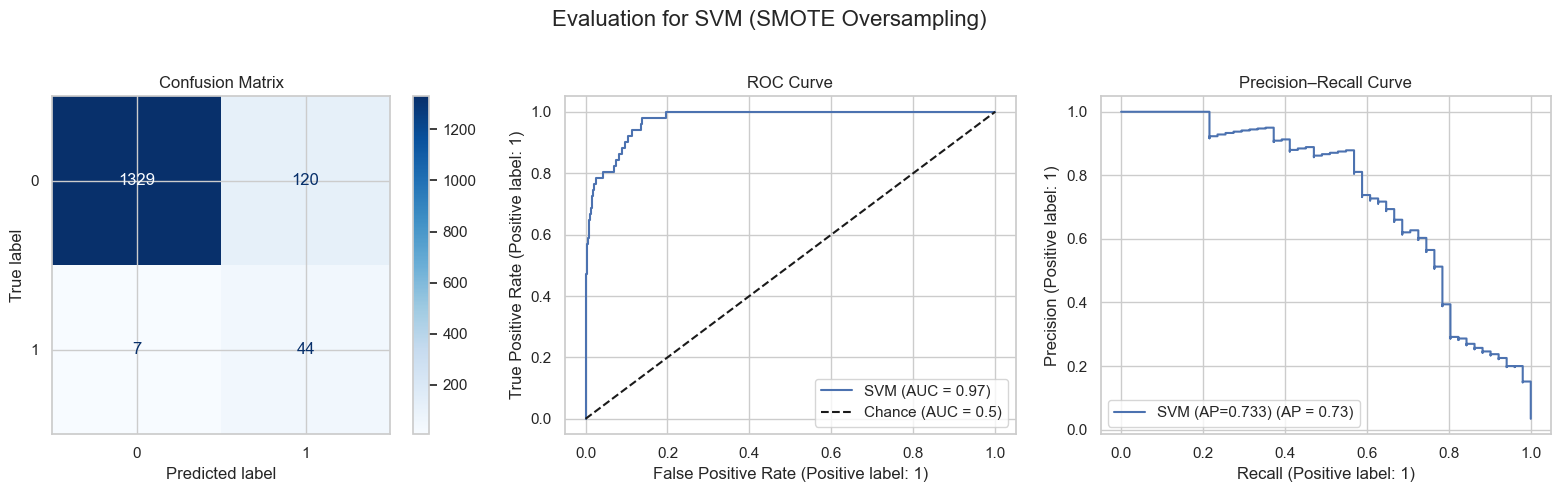

{'Accuracy': 0.9153333333333333,
 'Precision': 0.2682926829268293,
 'Recall': 0.8627450980392157,
 'F1': 0.4093023255813954,
 'ROC_AUC': 0.9740997848414727,
 'PR_AUC': 0.7327675060364042}

In [56]:
print("\n--- Scenario 3: SMOTE Oversampling ---")
scenario = 'SMOTE Oversampling'
best_models_info[scenario] = {}
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=N_JOBS)

# --- Random Forest with SMOTE ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_smote = ImbPipeline([('preprocessor', preprocessor), ('sampler', smote), ('model', rf_model_unweighted)])
grid_search_rf_smote = GridSearchCV(pipeline_rf_smote, param_grid_rf, cv=cv_stratified, scoring=scoring_multi, refit='ap', n_jobs=N_JOBS, verbose=1)
grid_search_rf_smote.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_smote.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_smote.best_estimator_, X_test_model, y_test, results)

# --- SVM with SMOTE ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_smote = ImbPipeline([('preprocessor', preprocessor), ('sampler', smote), ('model', svm_model_unweighted)])
grid_search_svm_smote = GridSearchCV(pipeline_svm_smote, param_grid_svm, cv=cv_stratified, scoring=scoring_multi, refit='ap', n_jobs=N_JOBS, verbose=1)
grid_search_svm_smote.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_smote.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_smote.best_estimator_, X_test_model, y_test, results)

### Scenario 4: Specialized Multi-GAN Oversampling

This scenario implements the core hypothesis of the thesis. We train a separate GAN for each major failure type to learn its specific data signature. This involves a hyperparameter tuning loop to find the best GAN settings before training the final classifiers.

The tabgan library implements a variant of the Conditional Tabular GAN (CTGAN), which is particularly effective for tabular data. It uses a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** loss function, which is known to provide more stable training than traditional GANs. Furthermore, it incorporates an **adversarial filter** after generation; a secondary classifier (LightGBM) is trained to distinguish between the real and synthetic data, and only the highest-quality synthetic samples (those that fool the filter) are retained. Our multi-GAN approach leverages this powerful architecture by creating a dedicated, expert CTGAN for each failure mode.

Process:
1.  Hyperparameter Search: A grid of GAN and adversarial model parameters is defined. The loop iterates through this grid.
2.  Specialized GAN Training (per parameter set): For each parameter combination, a separate GAN is trained on the data for each specific failure type (Heat Dissipation, Power, Overstrain, Tool Wear).
3.  Data Generation & Augmentation: Synthetic data is generated from each specialized GAN. This data is then combined with the original training set.
4.  Validation: A fast, non-tuned Random Forest model is trained on the augmented data and evaluated on the validation set. The GAN parameters that yield the highest ROC AUC on the validation set are considered the best.
5.  Final Model Training: Using the best GAN parameters found, a final, high-quality augmented dataset is generated. GridSearchCV is then used to train and tune the RF and SVM classifiers on this dataset.
6.  Final Evaluation: The performance of the final, tuned classifiers is measured on the unseen test set.


--- Scenario 4: Specialized Multi-GAN Oversampling (TabGAN with Optuna) ---

Finding best RF parameters on original data to use for Optuna validation...
--> Found best RF params for Optuna loop: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': 10, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Pre-processing static data for faster Optuna trials...
Pre-processing complete. Starting Optuna study...

--- Optuna Trial #0 ---
--> Testing Params: {'patience': 380, 'batch_size': 60, 'adv_learning_rate': 0.027586986748117055}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #0: Validation PR AUC (AP) = 0.8006 ---

--- Optuna Trial #1 ---
--> Testing Params: {'patience': 600, 'batch_size': 10, 'adv_learning_rate': 0.012414180611485873}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #1: Validation PR AUC (AP) = 0.8355 ---

--- Optuna Trial #2 ---
--> Testing Params: {'patience': 60, 'batch_size': 60, 'adv_learning_rate': 0.0230095062132501}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #2: Validation PR AUC (AP) = 0.7306 ---

--- Optuna Trial #3 ---
--> Testing Params: {'patience': 710, 'batch_size': 10, 'adv_learning_rate': 0.03836576984791727}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #3: Validation PR AUC (AP) = 0.7805 ---

--- Optuna Trial #4 ---
--> Testing Params: {'patience': 840, 'batch_size': 20, 'adv_learning_rate': 0.012866770011394156}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #4: Validation PR AUC (AP) = 0.8154 ---

--- Optuna Trial #5 ---
--> Testing Params: {'patience': 190, 'batch_size': 20, 'adv_learning_rate': 0.02069830835864267}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #5: Validation PR AUC (AP) = 0.7357 ---

--- Optuna Trial #6 ---
--> Testing Params: {'patience': 440, 'batch_size': 20, 'adv_learning_rate': 0.023354584677722303}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #6: Validation PR AUC (AP) = 0.8313 ---

--- Optuna Trial #7 ---
--> Testing Params: {'patience': 140, 'batch_size': 20, 'adv_learning_rate': 0.016617734201183915}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #7: Validation PR AUC (AP) = 0.8321 ---

--- Optuna Trial #8 ---
--> Testing Params: {'patience': 460, 'batch_size': 50, 'adv_learning_rate': 0.013189113194021983}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #8: Validation PR AUC (AP) = 0.8556 ---

--- Optuna Trial #9 ---
--> Testing Params: {'patience': 520, 'batch_size': 40, 'adv_learning_rate': 0.010665124635076767}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #9: Validation PR AUC (AP) = 0.8139 ---

--- Optuna Trial #10 ---
--> Testing Params: {'patience': 610, 'batch_size': 20, 'adv_learning_rate': 0.010943719712988126}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #10: Validation PR AUC (AP) = 0.7903 ---

--- Optuna Trial #11 ---
--> Testing Params: {'patience': 950, 'batch_size': 60, 'adv_learning_rate': 0.030669288467505072}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #11: Validation PR AUC (AP) = 0.8004 ---

--- Optuna Trial #12 ---
--> Testing Params: {'patience': 310, 'batch_size': 10, 'adv_learning_rate': 0.02581958930831549}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #12: Validation PR AUC (AP) = 0.8288 ---

--- Optuna Trial #13 ---
--> Testing Params: {'patience': 450, 'batch_size': 10, 'adv_learning_rate': 0.019866721614662203}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #13: Validation PR AUC (AP) = 0.8557 ---

--- Optuna Trial #14 ---
--> Testing Params: {'patience': 40, 'batch_size': 60, 'adv_learning_rate': 0.014315320426348706}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #14: Validation PR AUC (AP) = 0.7602 ---

--- Optuna Trial #15 ---
--> Testing Params: {'patience': 670, 'batch_size': 20, 'adv_learning_rate': 0.020564215593249984}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #15: Validation PR AUC (AP) = 0.8070 ---

--- Optuna Trial #16 ---
--> Testing Params: {'patience': 550, 'batch_size': 20, 'adv_learning_rate': 0.038348476280432746}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #16: Validation PR AUC (AP) = 0.8172 ---

--- Optuna Trial #17 ---
--> Testing Params: {'patience': 780, 'batch_size': 60, 'adv_learning_rate': 0.0345732134009089}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #17: Validation PR AUC (AP) = 0.7705 ---

--- Optuna Trial #18 ---
--> Testing Params: {'patience': 600, 'batch_size': 60, 'adv_learning_rate': 0.011305188160404048}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #18: Validation PR AUC (AP) = 0.7796 ---

--- Optuna Trial #19 ---
--> Testing Params: {'patience': 200, 'batch_size': 10, 'adv_learning_rate': 0.015698869384459076}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #19: Validation PR AUC (AP) = 0.8165 ---

--- Optuna Trial #20 ---
--> Testing Params: {'patience': 730, 'batch_size': 50, 'adv_learning_rate': 0.018579132744627434}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #20: Validation PR AUC (AP) = 0.8148 ---

--- Optuna Trial #21 ---
--> Testing Params: {'patience': 470, 'batch_size': 10, 'adv_learning_rate': 0.013799723891077495}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #21: Validation PR AUC (AP) = 0.8198 ---

--- Optuna Trial #22 ---
--> Testing Params: {'patience': 430, 'batch_size': 50, 'adv_learning_rate': 0.016212045128636665}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #22: Validation PR AUC (AP) = 0.7263 ---

--- Optuna Trial #23 ---
--> Testing Params: {'patience': 220, 'batch_size': 40, 'adv_learning_rate': 0.011399318902737812}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #23: Validation PR AUC (AP) = 0.8071 ---

--- Optuna Trial #24 ---
--> Testing Params: {'patience': 740, 'batch_size': 10, 'adv_learning_rate': 0.016858779692565436}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #24: Validation PR AUC (AP) = 0.8190 ---

--- Optuna Trial #25 ---
--> Testing Params: {'patience': 510, 'batch_size': 30, 'adv_learning_rate': 0.016197433858933925}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #25: Validation PR AUC (AP) = 0.7692 ---

--- Optuna Trial #26 ---
--> Testing Params: {'patience': 150, 'batch_size': 30, 'adv_learning_rate': 0.03824883043729717}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #26: Validation PR AUC (AP) = 0.7848 ---

--- Optuna Trial #27 ---
--> Testing Params: {'patience': 880, 'batch_size': 40, 'adv_learning_rate': 0.010632201468892608}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #27: Validation PR AUC (AP) = 0.7888 ---

--- Optuna Trial #28 ---
--> Testing Params: {'patience': 290, 'batch_size': 60, 'adv_learning_rate': 0.010335538755928226}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #28: Validation PR AUC (AP) = 0.8334 ---

--- Optuna Trial #29 ---
--> Testing Params: {'patience': 700, 'batch_size': 10, 'adv_learning_rate': 0.01051361261224108}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #29: Validation PR AUC (AP) = 0.8256 ---

--- Optuna Trial #30 ---
--> Testing Params: {'patience': 930, 'batch_size': 30, 'adv_learning_rate': 0.029498868855837464}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #30: Validation PR AUC (AP) = 0.8141 ---

--- Optuna Trial #31 ---
--> Testing Params: {'patience': 270, 'batch_size': 60, 'adv_learning_rate': 0.010159003974863882}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #31: Validation PR AUC (AP) = 0.8297 ---

--- Optuna Trial #32 ---
--> Testing Params: {'patience': 430, 'batch_size': 60, 'adv_learning_rate': 0.014036278573231382}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #32: Validation PR AUC (AP) = 0.7895 ---

--- Optuna Trial #33 ---
--> Testing Params: {'patience': 480, 'batch_size': 10, 'adv_learning_rate': 0.018340650279243653}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #33: Validation PR AUC (AP) = 0.8183 ---

--- Optuna Trial #34 ---
--> Testing Params: {'patience': 400, 'batch_size': 50, 'adv_learning_rate': 0.010640288368882892}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #34: Validation PR AUC (AP) = 0.8635 ---

--- Optuna Trial #35 ---
--> Testing Params: {'patience': 290, 'batch_size': 60, 'adv_learning_rate': 0.03900484274350579}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #35: Validation PR AUC (AP) = 0.8334 ---

--- Optuna Trial #36 ---
--> Testing Params: {'patience': 480, 'batch_size': 50, 'adv_learning_rate': 0.0128205394559815}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #36: Validation PR AUC (AP) = 0.7917 ---

--- Optuna Trial #37 ---
--> Testing Params: {'patience': 380, 'batch_size': 10, 'adv_learning_rate': 0.010552259421079374}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #37: Validation PR AUC (AP) = 0.8438 ---

--- Optuna Trial #38 ---
--> Testing Params: {'patience': 210, 'batch_size': 10, 'adv_learning_rate': 0.01019758996665828}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #38: Validation PR AUC (AP) = 0.8259 ---

--- Optuna Trial #39 ---
--> Testing Params: {'patience': 400, 'batch_size': 20, 'adv_learning_rate': 0.010245276775837713}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #39: Validation PR AUC (AP) = 0.8109 ---

--- Optuna Trial #40 ---
--> Testing Params: {'patience': 410, 'batch_size': 10, 'adv_learning_rate': 0.010200014919789861}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #40: Validation PR AUC (AP) = 0.8322 ---

--- Optuna Trial #41 ---
--> Testing Params: {'patience': 180, 'batch_size': 40, 'adv_learning_rate': 0.023137047167864234}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #41: Validation PR AUC (AP) = 0.8191 ---

--- Optuna Trial #42 ---
--> Testing Params: {'patience': 520, 'batch_size': 50, 'adv_learning_rate': 0.010237227871705808}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #42: Validation PR AUC (AP) = 0.8023 ---

--- Optuna Trial #43 ---
--> Testing Params: {'patience': 580, 'batch_size': 10, 'adv_learning_rate': 0.01316688503468442}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #43: Validation PR AUC (AP) = 0.8242 ---

--- Optuna Trial #44 ---
--> Testing Params: {'patience': 600, 'batch_size': 10, 'adv_learning_rate': 0.027864755135974965}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #44: Validation PR AUC (AP) = 0.8355 ---

--- Optuna Trial #45 ---
--> Testing Params: {'patience': 390, 'batch_size': 40, 'adv_learning_rate': 0.01218672189110024}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #45: Validation PR AUC (AP) = 0.8190 ---

--- Optuna Trial #46 ---
--> Testing Params: {'patience': 510, 'batch_size': 10, 'adv_learning_rate': 0.020449270131156525}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #46: Validation PR AUC (AP) = 0.7493 ---

--- Optuna Trial #47 ---
--> Testing Params: {'patience': 330, 'batch_size': 10, 'adv_learning_rate': 0.012892811527584255}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #47: Validation PR AUC (AP) = 0.8173 ---

--- Optuna Trial #48 ---
--> Testing Params: {'patience': 470, 'batch_size': 40, 'adv_learning_rate': 0.02946351600670414}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #48: Validation PR AUC (AP) = 0.7958 ---

--- Optuna Trial #49 ---
--> Testing Params: {'patience': 310, 'batch_size': 10, 'adv_learning_rate': 0.02071526758558994}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #49: Validation PR AUC (AP) = 0.8288 ---

--- Optuna Trial #50 ---
--> Testing Params: {'patience': 1000, 'batch_size': 10, 'adv_learning_rate': 0.01353137379247188}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #50: Validation PR AUC (AP) = 0.8024 ---

--- Optuna Trial #51 ---
--> Testing Params: {'patience': 800, 'batch_size': 10, 'adv_learning_rate': 0.02789259764861195}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #51: Validation PR AUC (AP) = 0.8568 ---

--- Optuna Trial #52 ---
--> Testing Params: {'patience': 970, 'batch_size': 10, 'adv_learning_rate': 0.024969244449618944}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #52: Validation PR AUC (AP) = 0.7878 ---

--- Optuna Trial #53 ---
--> Testing Params: {'patience': 840, 'batch_size': 10, 'adv_learning_rate': 0.03877564796930438}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #53: Validation PR AUC (AP) = 0.8073 ---

--- Optuna Trial #54 ---
--> Testing Params: {'patience': 740, 'batch_size': 10, 'adv_learning_rate': 0.029404429725081914}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #54: Validation PR AUC (AP) = 0.8190 ---

--- Optuna Trial #55 ---
--> Testing Params: {'patience': 780, 'batch_size': 10, 'adv_learning_rate': 0.022971751300642714}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #55: Validation PR AUC (AP) = 0.8110 ---

--- Optuna Trial #56 ---
--> Testing Params: {'patience': 940, 'batch_size': 60, 'adv_learning_rate': 0.013604632584759163}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #56: Validation PR AUC (AP) = 0.7321 ---

--- Optuna Trial #57 ---
--> Testing Params: {'patience': 420, 'batch_size': 60, 'adv_learning_rate': 0.022834455596405807}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #57: Validation PR AUC (AP) = 0.8472 ---

--- Optuna Trial #58 ---
--> Testing Params: {'patience': 520, 'batch_size': 60, 'adv_learning_rate': 0.024414589135871235}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #58: Validation PR AUC (AP) = 0.7746 ---

--- Optuna Trial #59 ---
--> Testing Params: {'patience': 210, 'batch_size': 60, 'adv_learning_rate': 0.020949185231303607}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #59: Validation PR AUC (AP) = 0.8225 ---

--- Optuna Trial #60 ---
--> Testing Params: {'patience': 350, 'batch_size': 60, 'adv_learning_rate': 0.025741337246961333}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #60: Validation PR AUC (AP) = 0.8329 ---

--- Optuna Trial #61 ---
--> Testing Params: {'patience': 450, 'batch_size': 60, 'adv_learning_rate': 0.019853295251852907}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #61: Validation PR AUC (AP) = 0.8297 ---

--- Optuna Trial #62 ---
--> Testing Params: {'patience': 650, 'batch_size': 20, 'adv_learning_rate': 0.013212913397688021}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #62: Validation PR AUC (AP) = 0.7914 ---

--- Optuna Trial #63 ---
--> Testing Params: {'patience': 270, 'batch_size': 50, 'adv_learning_rate': 0.013640592970661333}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #63: Validation PR AUC (AP) = 0.8393 ---

--- Optuna Trial #64 ---
--> Testing Params: {'patience': 170, 'batch_size': 50, 'adv_learning_rate': 0.015059102083057996}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #64: Validation PR AUC (AP) = 0.7954 ---

--- Optuna Trial #65 ---
--> Testing Params: {'patience': 260, 'batch_size': 50, 'adv_learning_rate': 0.013222099293198076}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #65: Validation PR AUC (AP) = 0.7984 ---

--- Optuna Trial #66 ---
--> Testing Params: {'patience': 440, 'batch_size': 40, 'adv_learning_rate': 0.015932080887048346}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #66: Validation PR AUC (AP) = 0.8349 ---

--- Optuna Trial #67 ---
--> Testing Params: {'patience': 10, 'batch_size': 40, 'adv_learning_rate': 0.01008369753285435}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #67: Validation PR AUC (AP) = 0.7883 ---

--- Optuna Trial #68 ---
--> Testing Params: {'patience': 30, 'batch_size': 10, 'adv_learning_rate': 0.03194802710309259}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #68: Validation PR AUC (AP) = 0.8027 ---

--- Optuna Trial #69 ---
--> Testing Params: {'patience': 670, 'batch_size': 50, 'adv_learning_rate': 0.014291870111379574}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #69: Validation PR AUC (AP) = 0.8218 ---

--- Optuna Trial #70 ---
--> Testing Params: {'patience': 320, 'batch_size': 50, 'adv_learning_rate': 0.011634420663408005}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #70: Validation PR AUC (AP) = 0.7936 ---

--- Optuna Trial #71 ---
--> Testing Params: {'patience': 530, 'batch_size': 10, 'adv_learning_rate': 0.010308855196381273}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #71: Validation PR AUC (AP) = 0.8114 ---

--- Optuna Trial #72 ---
--> Testing Params: {'patience': 330, 'batch_size': 50, 'adv_learning_rate': 0.015956921398665676}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #72: Validation PR AUC (AP) = 0.8591 ---

--- Optuna Trial #73 ---
--> Testing Params: {'patience': 330, 'batch_size': 50, 'adv_learning_rate': 0.01705343894000021}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #73: Validation PR AUC (AP) = 0.8591 ---

--- Optuna Trial #74 ---
--> Testing Params: {'patience': 360, 'batch_size': 50, 'adv_learning_rate': 0.017837704757401103}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #74: Validation PR AUC (AP) = 0.7778 ---

--- Optuna Trial #75 ---
--> Testing Params: {'patience': 270, 'batch_size': 40, 'adv_learning_rate': 0.017700492886152164}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #75: Validation PR AUC (AP) = 0.8265 ---

--- Optuna Trial #76 ---
--> Testing Params: {'patience': 350, 'batch_size': 50, 'adv_learning_rate': 0.01993139399692394}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #76: Validation PR AUC (AP) = 0.8171 ---

--- Optuna Trial #77 ---
--> Testing Params: {'patience': 340, 'batch_size': 60, 'adv_learning_rate': 0.016660526312148982}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #77: Validation PR AUC (AP) = 0.8274 ---

--- Optuna Trial #78 ---
--> Testing Params: {'patience': 530, 'batch_size': 50, 'adv_learning_rate': 0.014443044580812454}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #78: Validation PR AUC (AP) = 0.8186 ---

--- Optuna Trial #79 ---
--> Testing Params: {'patience': 960, 'batch_size': 40, 'adv_learning_rate': 0.0183851461369438}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #79: Validation PR AUC (AP) = 0.8035 ---

--- Optuna Trial #80 ---
--> Testing Params: {'patience': 400, 'batch_size': 40, 'adv_learning_rate': 0.010191890689322377}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #80: Validation PR AUC (AP) = 0.8043 ---

--- Optuna Trial #81 ---
--> Testing Params: {'patience': 280, 'batch_size': 50, 'adv_learning_rate': 0.015311067060974562}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #81: Validation PR AUC (AP) = 0.8518 ---

--- Optuna Trial #82 ---
--> Testing Params: {'patience': 190, 'batch_size': 50, 'adv_learning_rate': 0.017445462757512402}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #82: Validation PR AUC (AP) = 0.8327 ---

--- Optuna Trial #83 ---
--> Testing Params: {'patience': 380, 'batch_size': 50, 'adv_learning_rate': 0.014303399168021322}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #83: Validation PR AUC (AP) = 0.8017 ---

--- Optuna Trial #84 ---
--> Testing Params: {'patience': 690, 'batch_size': 30, 'adv_learning_rate': 0.027704135077396195}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #84: Validation PR AUC (AP) = 0.8338 ---

--- Optuna Trial #85 ---
--> Testing Params: {'patience': 390, 'batch_size': 20, 'adv_learning_rate': 0.016437808255151936}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #85: Validation PR AUC (AP) = 0.7855 ---

--- Optuna Trial #86 ---
--> Testing Params: {'patience': 530, 'batch_size': 50, 'adv_learning_rate': 0.020157906664916223}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #86: Validation PR AUC (AP) = 0.8186 ---

--- Optuna Trial #87 ---
--> Testing Params: {'patience': 440, 'batch_size': 20, 'adv_learning_rate': 0.023672797884178913}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #87: Validation PR AUC (AP) = 0.8313 ---

--- Optuna Trial #88 ---
--> Testing Params: {'patience': 520, 'batch_size': 60, 'adv_learning_rate': 0.011190745265665037}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #88: Validation PR AUC (AP) = 0.7746 ---

--- Optuna Trial #89 ---
--> Testing Params: {'patience': 10, 'batch_size': 50, 'adv_learning_rate': 0.03705881043279501}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #89: Validation PR AUC (AP) = 0.7495 ---

--- Optuna Trial #90 ---
--> Testing Params: {'patience': 850, 'batch_size': 20, 'adv_learning_rate': 0.03139514807031087}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #90: Validation PR AUC (AP) = 0.8094 ---

--- Optuna Trial #91 ---
--> Testing Params: {'patience': 270, 'batch_size': 50, 'adv_learning_rate': 0.013886231316467134}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #91: Validation PR AUC (AP) = 0.8393 ---

--- Optuna Trial #92 ---
--> Testing Params: {'patience': 90, 'batch_size': 40, 'adv_learning_rate': 0.01476790273570265}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #92: Validation PR AUC (AP) = 0.8140 ---

--- Optuna Trial #93 ---
--> Testing Params: {'patience': 360, 'batch_size': 50, 'adv_learning_rate': 0.01518197122496405}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #93: Validation PR AUC (AP) = 0.7778 ---

--- Optuna Trial #94 ---
--> Testing Params: {'patience': 180, 'batch_size': 60, 'adv_learning_rate': 0.013710110966513308}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #94: Validation PR AUC (AP) = 0.7473 ---

--- Optuna Trial #95 ---
--> Testing Params: {'patience': 320, 'batch_size': 40, 'adv_learning_rate': 0.01408866078177677}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #95: Validation PR AUC (AP) = 0.8252 ---

--- Optuna Trial #96 ---
--> Testing Params: {'patience': 380, 'batch_size': 50, 'adv_learning_rate': 0.01007693211806192}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #96: Validation PR AUC (AP) = 0.8017 ---

--- Optuna Trial #97 ---
--> Testing Params: {'patience': 260, 'batch_size': 20, 'adv_learning_rate': 0.011309752316889294}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #97: Validation PR AUC (AP) = 0.7891 ---

--- Optuna Trial #98 ---
--> Testing Params: {'patience': 830, 'batch_size': 10, 'adv_learning_rate': 0.02896731012782345}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #98: Validation PR AUC (AP) = 0.8475 ---

--- Optuna Trial #99 ---
--> Testing Params: {'patience': 920, 'batch_size': 10, 'adv_learning_rate': 0.030793254730188874}


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #99: Validation PR AUC (AP) = 0.8375 ---

========================= Optuna HPO Complete =========================
Best Validation PR AUC (AP) found: 0.8635
Best Hyperparameters: {'patience': 400, 'batch_size': 50, 'adv_learning_rate': 0.010640288368882892}

Training Random Forest on TabGAN (specialized in-fold oversampling)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Evaluating Random Forest (GAN Oversampling) ---
Inference Time: 0.16 seconds
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1449
           1       0.57      0.88      0.69        51

    accuracy                           0.97      1500
   macro avg       0.78      0.93      0.84      1500
weighted avg       0.98      0.97      0.98      1500

ROC AUC Score: 0.9894
PR AUC (Average Precision): 0.8574
------------------------------------------------------------


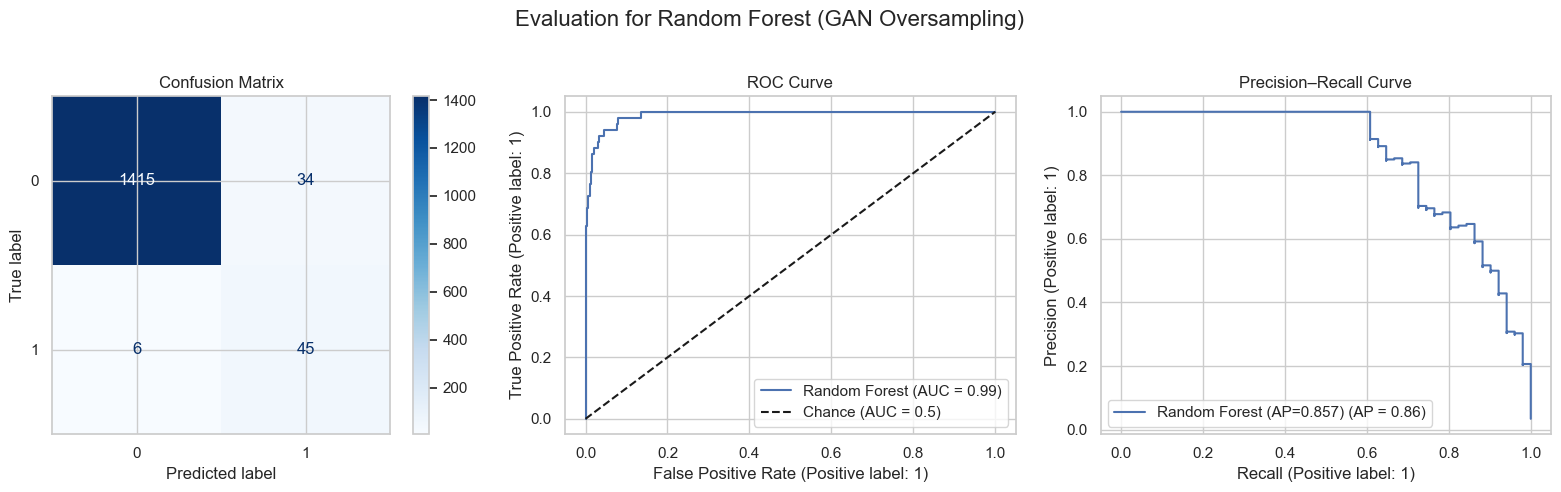


Training SVM on TabGAN (specialized in-fold oversampling)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

Fitting CTGAN transformers for each column:   0%|          | 0/7 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Evaluating SVM (GAN Oversampling) ---
Inference Time: 0.30 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1449
           1       0.56      0.69      0.62        51

    accuracy                           0.97      1500
   macro avg       0.78      0.83      0.80      1500
weighted avg       0.97      0.97      0.97      1500

ROC AUC Score: 0.9781
PR AUC (Average Precision): 0.7349
------------------------------------------------------------


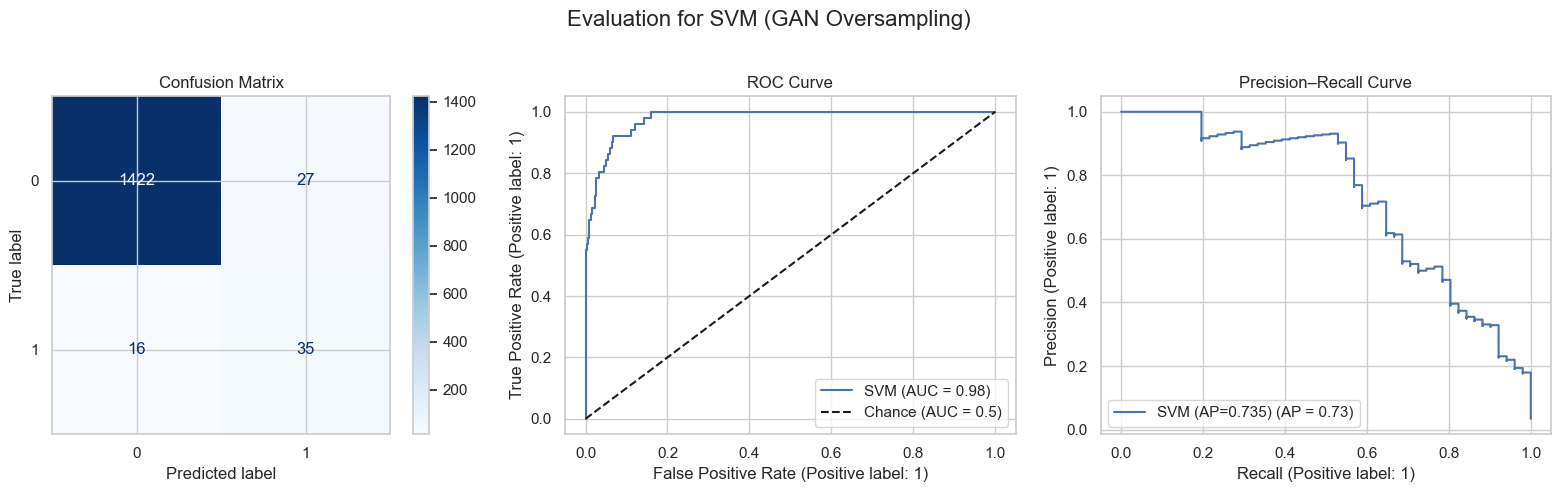

In [ ]:
###### =====================================================================================
# --- Scenario 4: Specialized Multi-GAN Oversampling (with Optuna HPO) ---
# =====================================================================================
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Warning: Optuna could not be imported. The advanced GAN HPO scenario will not run.")
    print("Try installing with: pip install optuna")
    OPTUNA_AVAILABLE = False

# --- Specialized multi-GAN sampler (per FailureType) ---
from imblearn.base import BaseSampler

class SpecializedTabGANSampler(BaseSampler):
    """
    Imbalanced-learn compatible sampler that:
      - splits minority class by FailureType
      - trains a separate TabGAN per FailureType subset
      - generates exactly enough synthetic minority rows to hit target_pos_ratio
    Expects X to include a 'FailureType' column and a 'Type' categorical column.
    """
    def __init__(self, gen_params, adv_params, categorical_features=None,
                 target_pos_ratio=0.5, failure_col='FailureType', random_state=42):
        self.gen_params = gen_params
        self.adv_params = adv_params
        self.categorical_features = categorical_features
        self.target_pos_ratio = target_pos_ratio
        self.failure_col = failure_col
        self.random_state = random_state

    def fit(self, X, y):
        return self

    def _fit_resample(self, X, y):
        X_df = pd.DataFrame(X).reset_index(drop=True)
        y_sr = pd.Series(y).reset_index(drop=True)
        if self.failure_col not in X_df.columns:
            raise ValueError(f"'{self.failure_col}' must be present in X for specialized multi-GAN.")

        # Split by class
        Xy = X_df.copy(); Xy['__y__'] = y_sr
        minority_all = Xy[Xy['__y__'] == 1].drop(columns='__y__')
        majority_all = Xy[Xy['__y__'] == 0].drop(columns='__y__')
        n0, n1 = len(majority_all), len(minority_all)

        # How many synthetic 1s we need to reach the target ratio
        r = float(self.target_pos_ratio)
        if not 0 < r < 1:
            raise ValueError("target_pos_ratio must be in (0,1)")
        total_k = int(np.ceil((r/(1.0 - r))*n0 - n1))

        if total_k <= 0 or n1 == 0:
            # nothing to do
            self.last_synth_df_ = pd.DataFrame()
            self.last_X_aug_ = X_df.to_numpy()
            self.last_y_aug_ = y_sr.to_numpy()
            return X_df.to_numpy(), y_sr.to_numpy()

        # Which failure types to model
        bad = {'No Failure', 'Random Failures'}
        ft_counts = minority_all[self.failure_col].value_counts()
        ft_counts = ft_counts[[ft for ft in ft_counts.index if ft not in bad]]
        if ft_counts.empty:
            # fallback: single-GAN on all minority rows (rare)
            fts = []
        else:
            fts = list(ft_counts.index)

        synth_parts = []
        rng = np.random.RandomState(self.random_state)

        if not fts:
            # Single-GAN fallback
            subset = minority_all.copy()
            k_need = total_k
            run_gen_params = dict(self.gen_params)
            bs = min(run_gen_params.get('batch_size', 64), len(subset))
            if bs % 10 != 0: bs = max(10, (bs // 10) * 10)
            run_gen_params['batch_size'] = bs

            existing_cols = list(subset.columns)
            cat_cols = [c for c in (self.categorical_features or []) if c in existing_cols]

            sampler = GANGenerator(
                gen_x_times=max(k_need / float(len(subset)), 1e-6),
                cat_cols=cat_cols,
                is_post_process=True,
                adversarial_model_params=self.adv_params,
                gen_params=run_gen_params
            )
            y_min = pd.Series([1]*len(subset), name='Target', index=subset.index)
            train_df = subset.drop(columns=[self.failure_col], errors='ignore')
            synth_df, _ = sampler.generate_data_pipe(
                train_df=train_df, target=y_min.to_frame(),
                test_df=None, only_generated_data=True
            )
            # trim/pad to exact k
            if len(synth_df) > k_need:
                synth_df = synth_df.sample(n=k_need, random_state=self.random_state)
            elif len(synth_df) < k_need:
                extra = synth_df.sample(n=(k_need - len(synth_df)), replace=True,
                                        random_state=self.random_state)
                synth_df = pd.concat([synth_df, extra], ignore_index=True)
            # put back FailureType for bookkeeping
            synth_df[self.failure_col] = subset[self.failure_col].iloc[0]
            synth_parts.append(synth_df)

        else:
            # Proportional allocation by failure type with rounding fix
            prop = ft_counts / ft_counts.sum()
            raw = prop * total_k
            k_floor = np.floor(raw).astype(int)
            remainder = total_k - int(k_floor.sum())
            order = (raw - k_floor).sort_values(ascending=False)
            for ft in order.index[:remainder]:
                k_floor.loc[ft] += 1

            for ft, k_need in k_floor.items():
                if k_need <= 0:
                    continue
                subset = minority_all[minority_all[self.failure_col] == ft]
                run_gen_params = dict(self.gen_params)
                bs = min(run_gen_params.get('batch_size', 64), len(subset))
                if bs % 10 != 0: bs = max(10, (bs // 10) * 10)
                run_gen_params['batch_size'] = bs

                existing_cols = list(subset.columns)
                cat_cols = [c for c in (self.categorical_features or []) if c in existing_cols]

                sampler = GANGenerator(
                    gen_x_times=max(k_need / float(len(subset)), 1e-6),
                    cat_cols=cat_cols,
                    is_post_process=True,
                    adversarial_model_params=self.adv_params,
                    gen_params=run_gen_params
                )
                y_min = pd.Series([1]*len(subset), name='Target', index=subset.index)
                train_df = subset.drop(columns=[self.failure_col], errors='ignore')
                synth_df, _ = sampler.generate_data_pipe(
                    train_df=train_df, target=y_min.to_frame(),
                    test_df=None, only_generated_data=True
                )
                # trim/pad to exact k per type
                if len(synth_df) > k_need:
                    synth_df = synth_df.sample(n=k_need, random_state=self.random_state)
                elif len(synth_df) < k_need:
                    extra = synth_df.sample(n=(k_need - len(synth_df)), replace=True,
                                            random_state=self.random_state)
                    synth_df = pd.concat([synth_df, extra], ignore_index=True)
                # annotate failure type for traceability
                synth_df[self.failure_col] = ft
                synth_parts.append(synth_df)

        synth_all = pd.concat(synth_parts, ignore_index=True) if synth_parts else pd.DataFrame()
        # Align columns to original X
        synth_all = synth_all.reindex(columns=X_df.columns, fill_value=np.nan)

        X_aug = pd.concat([X_df, synth_all], ignore_index=True)
        y_aug = np.concatenate([y_sr.to_numpy(), np.ones(len(synth_all), dtype=y_sr.dtype)])

        # keep for visualization / debugging
        self.last_synth_df_ = synth_all.copy()
        self.last_X_aug_ = X_aug.to_numpy()
        self.last_y_aug_ = y_aug
        return X_aug, y_aug

    # old imblearn compatibility
    def fit_resample(self, X, y):
        return self._fit_resample(X, y)



print("\n--- Scenario 4: Specialized Multi-GAN Oversampling (TabGAN with Optuna) ---")
scenario = 'GAN Oversampling'
best_models_info[scenario] = {}

# Suppress verbose LightGBM warnings from tabgan's adversarial filter and Optuna's trial logs
lgbm_logger = logging.getLogger('lightgbm')
lgbm_logger.setLevel(logging.ERROR)
optuna_logger = logging.getLogger('optuna')
optuna_logger.setLevel(logging.WARNING)


if not GAN_AVAILABLE or not PYTORCH_AVAILABLE or not OPTUNA_AVAILABLE:
    print(f"{scenario} skipped: TabGAN/PyTorch/Optuna not available.")
    # Define a placeholder for metrics to prevent errors in the results summary
    metrics_dict_keys = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC']
    results[scenario] = {
        'Random Forest': {m: np.nan for m in metrics_dict_keys},
        'SVM': {m: np.nan for m in metrics_dict_keys}
    }
else:
    # --- 1. Define the Objective Function for Optuna ---
    # This function encapsulates one full hyperparameter evaluation run.
    # Optuna will call this function, passing a 'trial' object that suggests parameter values.
    def objective(trial):
        """
        An objective function for Optuna to maximize. It trains the specialized GANs
        with a given set of hyperparameters and evaluates them on the validation set.
        """
        patience = trial.suggest_int("patience", 10, 1000, step=10) # Early stopping patience
        batch_size = trial.suggest_int("batch_size", 10, 60, step=10) # Batch size for training GAN ***to be fixed
        adv_learning_rate = trial.suggest_float("adv_learning_rate", 0.01, 0.04, log=True) # Learning rate for filter

        # --- Construct Parameter Dictionaries for TabGAN ---
        current_gen_params = {
            'epochs': 8000,  # A sufficiently high number for early stopping to trigger
            'patience': patience,
            'batch_size': batch_size,
            'seed': 42
        }
        current_adv_params = {
            'n_estimators': 300,
            'max_depth': 2,
            'learning_rate': adv_learning_rate,
            'random_state': 42,
            'verbose': -1,
            'n_jobs': N_JOBS,
        }

        print(f"\n--- Optuna Trial #{trial.number} ---")
        print(f"--> Testing Params: {trial.params}")

        # --- B. The Multi-GAN Loop ---
        try:
            all_synthetic_data = []
            failure_types_to_model = [ft for ft in df['FailureType'].unique() if ft not in ['No Failure', 'Random Failures']]

            num_majority = y_train.value_counts()[0]
            num_minority = y_train.value_counts()[1]
            total_synthetic_needed = num_majority - num_minority

            for failure_type in failure_types_to_model:
                X_train_failure_specific = X_train[X_train['FailureType'] == failure_type]
                if len(X_train_failure_specific) < 2: continue

                # Calculate how much data to make for this specific failure type
                proportion = len(X_train_failure_specific) / num_minority
                num_to_generate = int(total_synthetic_needed * proportion)
                if num_to_generate <= 0: continue
                
                # Ensure batch_size is not larger than the data subset
                specific_batch_size = min(current_gen_params['batch_size'], len(X_train_failure_specific))
                # Ensure batch_size is even and a multiple of pac=10
                if specific_batch_size % 10 != 0:
                    specific_batch_size = (specific_batch_size // 10) * 10
                if specific_batch_size == 0: specific_batch_size = 10 # Minimum valid batch size
                
                # Create a copy of gen_params to modify batch_size locally
                run_gen_params = current_gen_params.copy()
                run_gen_params['batch_size'] = specific_batch_size

                gen_x_times = num_to_generate / len(X_train_failure_specific)

        # --- C. GAN Instantiation and Training ---
                gan_sampler = GANGenerator(
                    gen_x_times=gen_x_times,
                    cat_cols=categorical_features,
                    is_post_process=True,
                    adversarial_model_params=current_adv_params,
                    gen_params=run_gen_params
                )

                X_train_gan_input = X_train_failure_specific.drop('FailureType', axis=1)
                y_gan_target = pd.Series([1] * len(X_train_gan_input), name='Target', index=X_train_gan_input.index)

                X_synthetic, _ = gan_sampler.generate_data_pipe(
                    train_df=X_train_gan_input,
                    target=y_gan_target.to_frame(),
                    test_df=None,
                    only_generated_data=True
                )
                all_synthetic_data.append(X_synthetic)

            if not all_synthetic_data:
                print("No synthetic data generated for this trial. Skipping.")
                # Return a very low value to signal a failed trial
                return -1.0
                
         # --- D. Validation and Returning the Score ---
            X_synthetic_all = pd.concat(all_synthetic_data, ignore_index=True)
            y_synthetic_all = pd.Series([1] * len(X_synthetic_all), name='Target')
            
            X_train_aug = pd.concat([X_train_model, X_synthetic_all], ignore_index=True)
            y_train_aug = pd.concat([y_train, y_synthetic_all], ignore_index=True)

            # --- Quick Validation on Pre-processed Data ---
            # 1. Transform ONLY the newly generated synthetic data
            X_synthetic_processed = preprocessor.transform(X_synthetic_all)

            # 2. Combine the pre-processed static data with the new synthetic data
            X_train_aug_processed = np.vstack([X_train_processed, X_synthetic_processed])

            # 3. Train a tuned RF model (no pipeline needed) on the fully processed data.
            # This model uses the hyperparameters we found just before starting the Optuna study,
            # making it a much better validator than a default RF.
            # We use clone() to ensure that each trial trains a fresh, unfitted model.
            optuna_validation_model = clone(tuned_rf_for_optuna)
            optuna_validation_model.fit(X_train_aug_processed, y_train_aug)
            
            # 4. Predict using the pre-processed validation set
            y_val_prob = optuna_validation_model.predict_proba(X_val_processed)[:, 1]
            current_pr_auc = average_precision_score(y_val, y_val_prob)
            print(f"--- Result for Trial #{trial.number}: Validation PR AUC (AP) = {current_pr_auc:.4f} ---")
            trial.report(current_pr_auc, step=1)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            return current_pr_auc


        except Exception as e:
            print(f"ERROR during Optuna trial #{trial.number}. Skipping. Error: {e}")
            import traceback
            traceback.print_exc()
            # Return a very low value to indicate failure
            return -1.0

    # ===================================================================
    # --- PRE-OPTUNA STEP: FIND BEST RF PARAMETERS ON ORIGINAL DATA ---
    # To make the Optuna evaluation model more robust and closer to the final
    # model, we first find the best RF hyperparameters on the original,
    # non-augmented data. These parameters will be used inside every Optuna trial.
    print("\nFinding best RF parameters on original data to use for Optuna validation...")
    
    # We need a temporary pipeline for this one-off grid search
    temp_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model_balanced)
    ])
    gs_for_optuna_model = GridSearchCV(
        temp_rf_pipeline,
        param_grid_rf,
        cv=cv_stratified,
        scoring=scoring_multi, refit='ap',
        n_jobs=N_JOBS, verbose=0
    )

    
    gs_for_optuna_model.fit(X_train_model, y_train)
    
    # Now, we extract just the 'model' step from the best pipeline.
    # This gives us a pre-configured, tuned RandomForestClassifier instance.
    tuned_rf_for_optuna = gs_for_optuna_model.best_estimator_.named_steps['model']
    
    print(f"--> Found best RF params for Optuna loop: {tuned_rf_for_optuna.get_params()}")
    # ===================================================================
            
    # ===================================================================
    # --- PRE-PROCESSING STEP TO ACCELERATE OPTUNA ---
    # We pre-process the static data (original training and validation sets) ONCE
    # to avoid repeating this work inside every single trial of the optimization loop.
    
    print("\nPre-processing static data for faster Optuna trials...")
    
    # We need to FIT the preprocessor on the training data and then TRANSFORM both sets.
    # Note: The original pipeline does this implicitly. Here, we do it explicitly.
    preprocessor.fit(X_train_model, y_train)
    X_train_processed = preprocessor.transform(X_train_model)
    X_val_processed = preprocessor.transform(X_val_model)
    
    print("Pre-processing complete. Starting Optuna study...")
    # ===================================================================

    # --- 2. Create and Run the Optuna Study ---
    sampler = optuna.samplers.TPESampler(n_ei_candidates=200, multivariate=True, group=True, seed=42, n_startup_trials=20)
    study = optuna.create_study(sampler=sampler,
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10) # Pruning starts after 3 trials
    )
    
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1) # n_jobs=1 is required for Reproducibility

    print(f"\n{'='*25} Optuna HPO Complete {'='*25}")
    print(f"Best Validation PR AUC (AP) found: {study.best_value:.4f}")  # was ROC AUC
    print(f"Best Hyperparameters: {study.best_params}")
    # === Build params for in-fold TabGAN (no pre-gen) ===
    best_gan_config = study.best_params
    # final_network_dim = best_gan_config['network_dim']
    
    final_gen_params = {
        'epochs': 8000,
        'patience': best_gan_config['patience'],
        'batch_size': best_gan_config['batch_size'],
        'seed': 42,
    }
    
    final_adv_params = {
        'n_estimators': 300,
        'max_depth': 2,
        'learning_rate': best_gan_config['adv_learning_rate'],
        'random_state': 42,
        'verbose': -1
    }

# --- 4. Train Final Classifiers on TabGAN (in-fold oversampling only) ---
if best_gan_config:
    # Local preprocessor for GAN pipelines: drop any columns we didn't name explicitly
    preprocessor_gan = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OrdinalEncoder(categories=[type_order]), categorical_features)  # categorical_features = ['Type']
        ],
        remainder='drop'
    )
    print("\nTraining Random Forest on TabGAN (specialized in-fold oversampling)...")
    
    sampler_in_cv = SpecializedTabGANSampler(
        gen_params=final_gen_params,
        adv_params=final_adv_params,
        categorical_features=['Type'],  # <-- categorical column(s) the GAN should treat as categorical
        target_pos_ratio=0.5,
        random_state=42
    )
    
    pipeline_rf_gan = ImbPipeline([
        ('sampler', sampler_in_cv),      # <-- GAN sees raw columns including 'Type' and 'FailureType'
        ('preprocessor', preprocessor_gan),
        ('model', rf_model_balanced),
    ])
    
    with joblib.parallel_backend('threading'):
        grid_search_rf_gan = GridSearchCV(
            pipeline_rf_gan, param_grid_rf, cv=cv_stratified,
            scoring=scoring_multi, refit='ap', n_jobs=1, verbose=1
        )
        # IMPORTANT: fit on X that includes 'FailureType'
        grid_search_rf_gan.fit(X_train, y_train)
    
    sampler_refit = grid_search_rf_gan.best_estimator_.named_steps['sampler']
    X_train_gan_aug = sampler_refit.last_X_aug_
    y_train_gan_aug = sampler_refit.last_y_aug_
    X_synth_final   = sampler_refit.last_synth_df_
    
    best_models_info[scenario]['Random Forest'] = {'model': grid_search_rf_gan.best_estimator_}
    # You can pass X_test (includes FailureType) or X_test_model (without it). Both are fine, since sampler is skipped at predict time.
    evaluate_model('Random Forest', scenario, grid_search_rf_gan.best_estimator_, X_test, y_test, results)

    print("\nTraining SVM on TabGAN (specialized in-fold oversampling)...")
    
    pipeline_svm_gan = ImbPipeline([
        ('sampler', sampler_in_cv),
        ('preprocessor', preprocessor_gan),
        ('model', svm_model_unweighted),
    ])
    
    with joblib.parallel_backend('threading'):
        grid_search_svm_gan = GridSearchCV(
            pipeline_svm_gan, param_grid_svm, cv=cv_stratified,
            scoring=scoring_multi, refit='ap', n_jobs=1, verbose=1
        )
        grid_search_svm_gan.fit(X_train, y_train)
    
    best_models_info[scenario]['SVM'] = {'model': grid_search_svm_gan.best_estimator_}
    evaluate_model('SVM', scenario, grid_search_svm_gan.best_estimator_, X_test, y_test, results)



## 8. Results Comparison

Compile the stored results from all scenarios and models into a DataFrame and visualize the comparisons.


--- Comparative Results ---


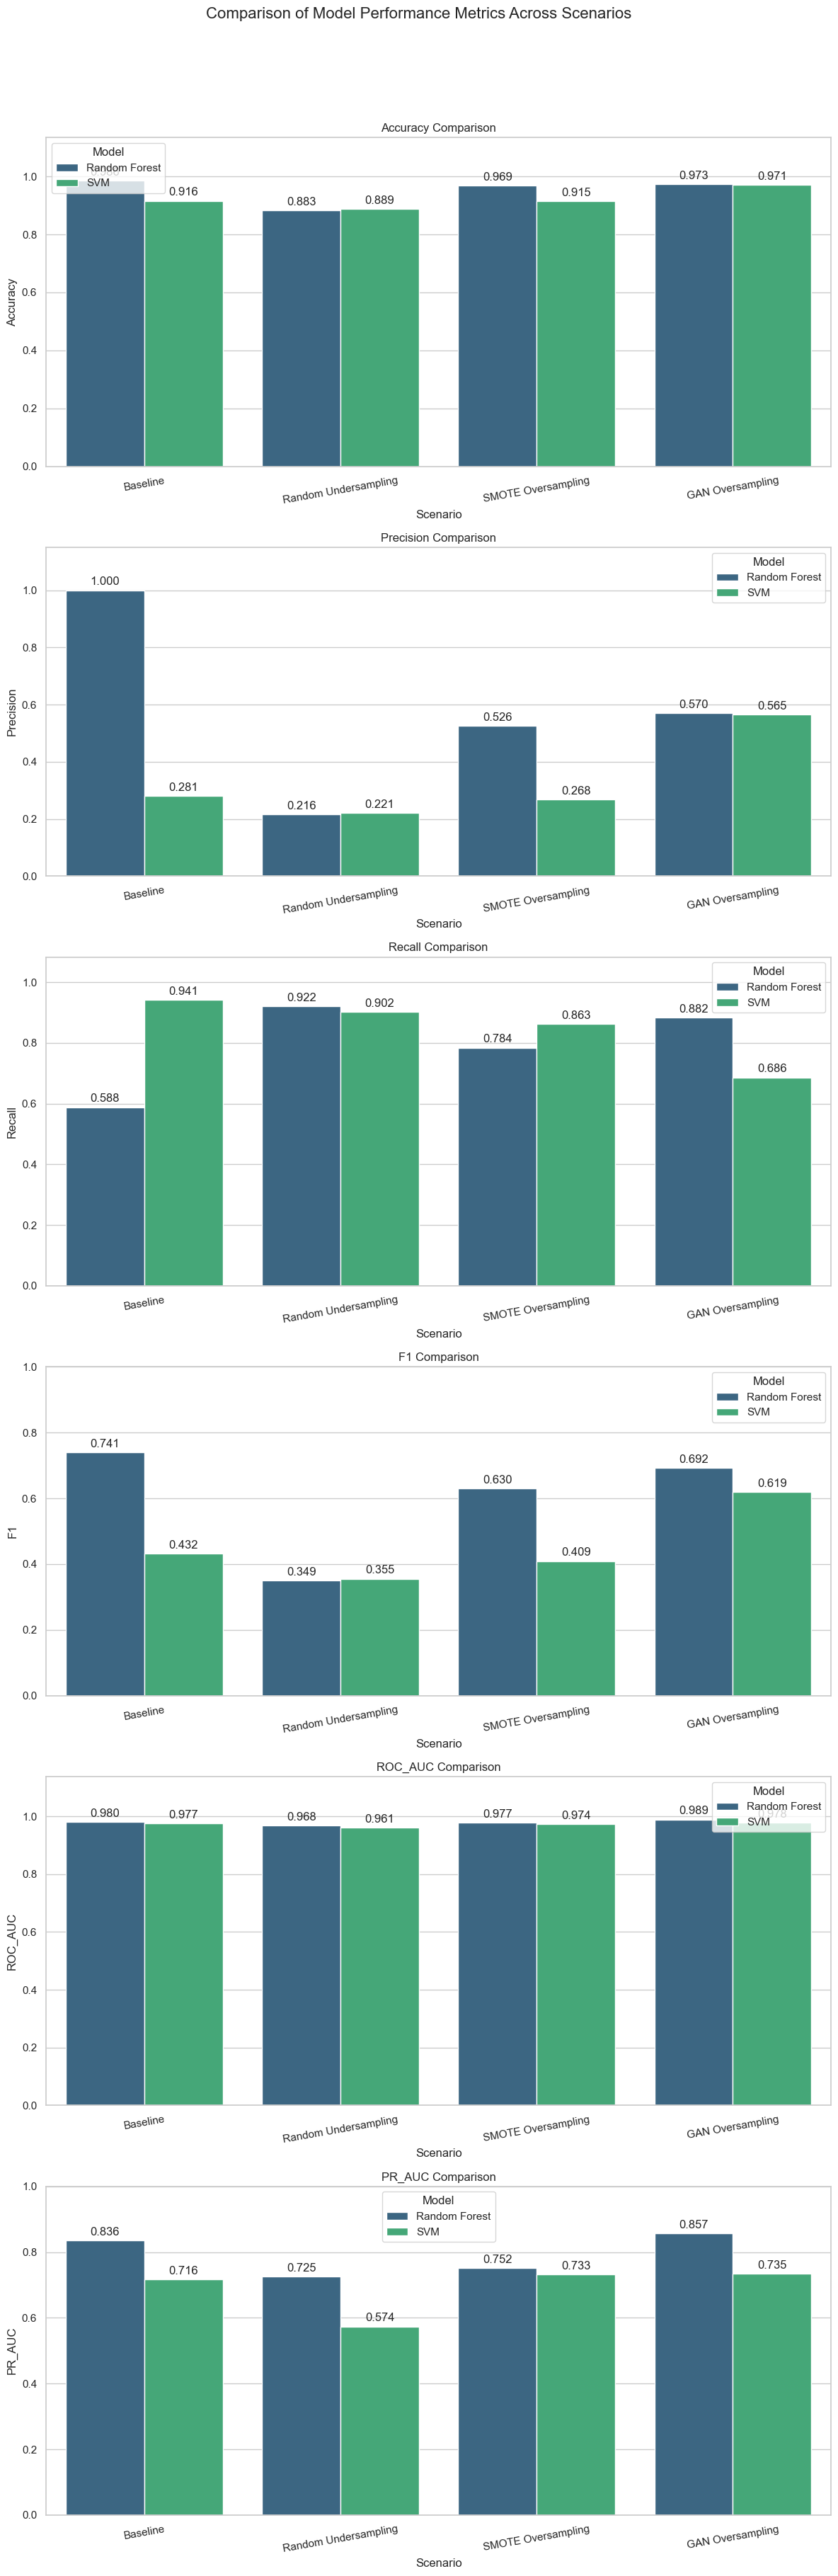

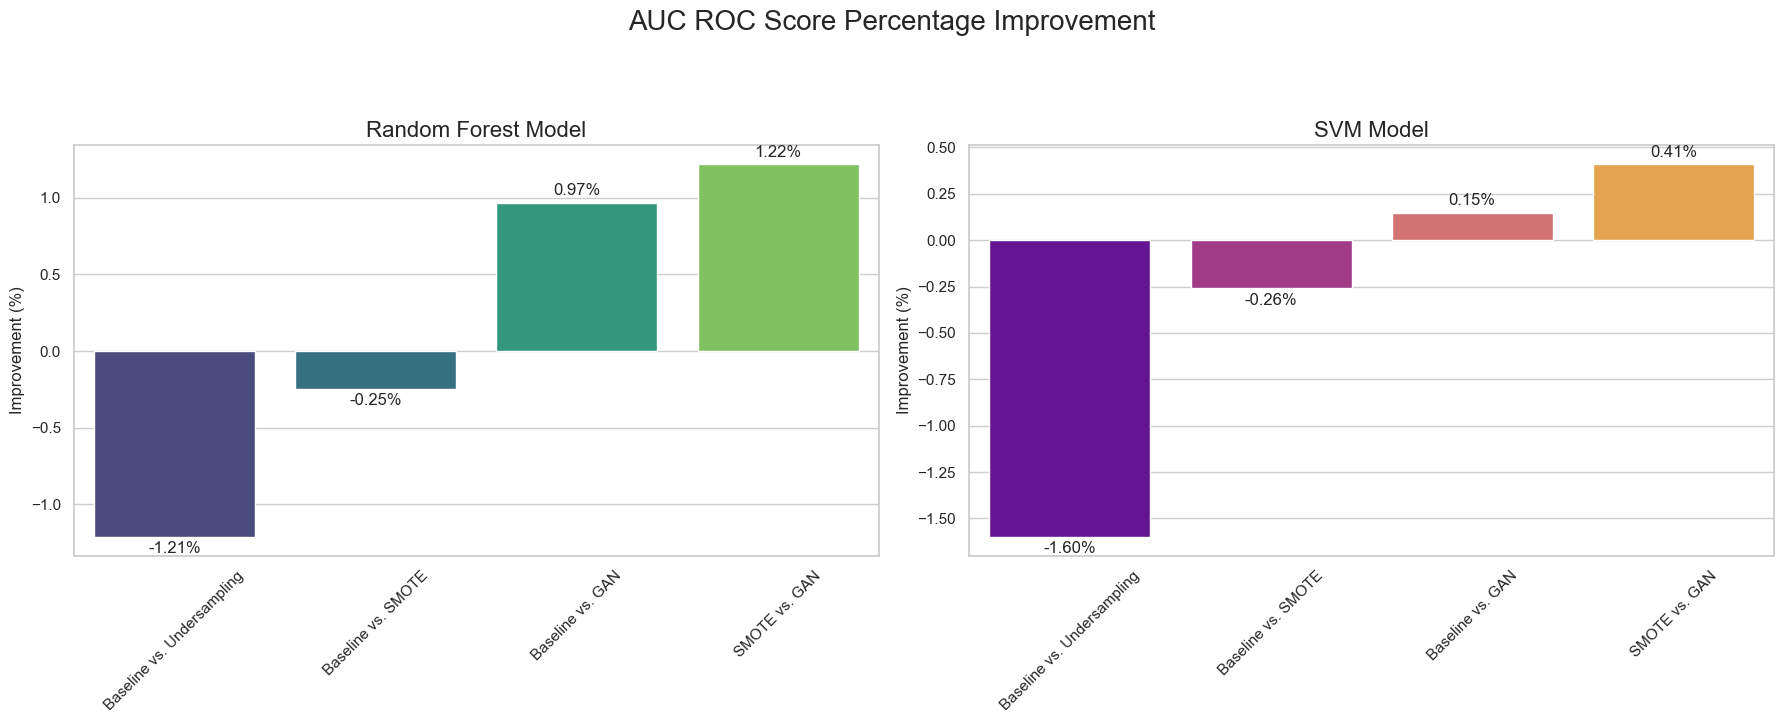

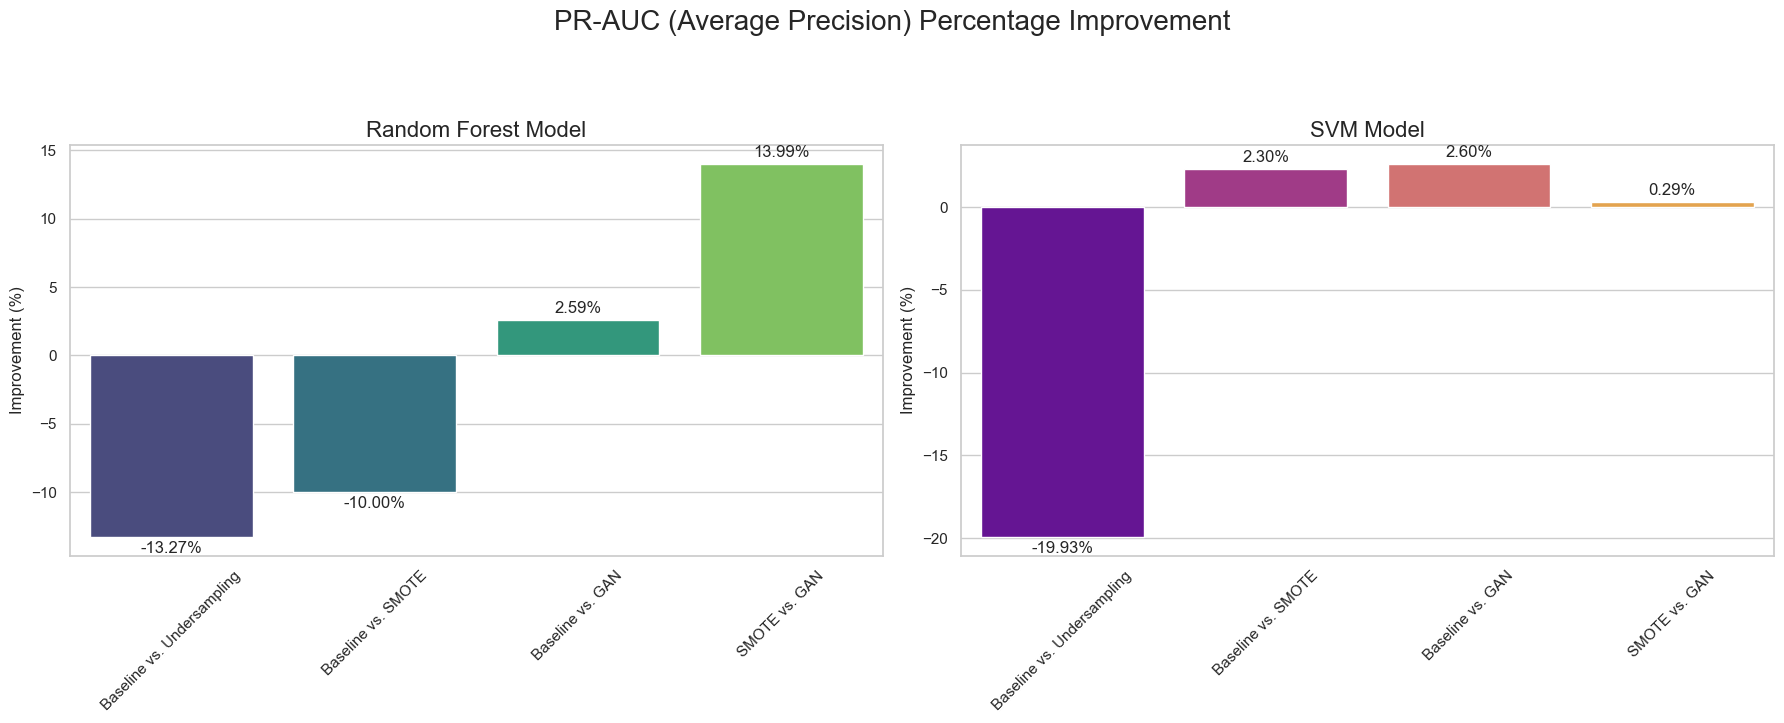

In [58]:
###### Convert results dictionary to DataFrame
results_list = []
for scenario, models in results.items():
    for model, metrics in models.items():
        # Add scenario and model names to the metrics dictionary
        metrics['Scenario'] = scenario
        metrics['Model'] = model
        results_list.append(metrics)

if results_list:
    results_df = pd.DataFrame(results_list)
    # Reorder columns for clarity
    results_df = results_df[['Scenario', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC']]
    
    # Format the DataFrame for better readability
    results_df_formatted = results_df.set_index(['Scenario', 'Model']).style.format("{:.4f}", na_rep="N/A").set_caption("Model Performance Metrics Across Scenarios")

    print("\n--- Comparative Results ---")
    display(results_df_formatted)

    # --- Visualization of Results ---
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 6 * len(metrics_to_plot)))
    fig.suptitle('Comparison of Model Performance Metrics Across Scenarios', fontsize=16, y=1.01)

    scenario_order = ['Baseline', 'Random Undersampling', 'SMOTE Oversampling', 'GAN Oversampling']
    
    for i, metric in enumerate(metrics_to_plot):
        sns.barplot(data=results_df, x='Scenario', y=metric, hue='Model', ax=axes[i], palette='viridis', order=scenario_order)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Scenario')
        axes[i].tick_params(axis='x', rotation=10)
        axes[i].legend(title='Model')
        # Add bar labels
        if not axes[i].patches:
            continue
        for container in axes[i].containers:
            axes[i].bar_label(container, fmt='%.3f', padding=3)
        axes[i].set_ylim(bottom=0, top=max(1.0, results_df[metric].max() * 1.15))

    plt.tight_layout(rect=[0, 0, 1, 0.98])

    # --- AUC ROC Percentage Difference ---------------------------------------------------------------------------------------------------------------

    # Isolate the data for each model to make comparisons easier
    rf_results_df = results_df[results_df['Model'] == 'Random Forest'].set_index('Scenario')
    svm_results_df = results_df[results_df['Model'] == 'SVM'].set_index('Scenario')
    
    # --- Calculations for Random Forest ---
    # Get the baseline and SMOTE scores to compare against
    baseline_rf_auc = rf_results_df.loc['Baseline', 'ROC_AUC']
    smote_rf_auc = rf_results_df.loc['SMOTE Oversampling', 'ROC_AUC']
    gan_rf_auc = rf_results_df.loc['GAN Oversampling', 'ROC_AUC']
    
    # Calculate the percentage differences
    rf_diffs = {
        'Baseline vs. Undersampling': ((rf_results_df.loc['Random Undersampling', 'ROC_AUC'] - baseline_rf_auc) / baseline_rf_auc) * 100,
        'Baseline vs. SMOTE': ((smote_rf_auc - baseline_rf_auc) / baseline_rf_auc) * 100,
        'Baseline vs. GAN': ((gan_rf_auc - baseline_rf_auc) / baseline_rf_auc) * 100,
        'SMOTE vs. GAN': ((gan_rf_auc - smote_rf_auc) / smote_rf_auc) * 100
    }
    
    # --- Calculations for SVM ---
    # Get the baseline and SMOTE scores to compare against
    baseline_svm_auc = svm_results_df.loc['Baseline', 'ROC_AUC']
    smote_svm_auc = svm_results_df.loc['SMOTE Oversampling', 'ROC_AUC']
    gan_svm_auc = svm_results_df.loc['GAN Oversampling', 'ROC_AUC']
    
    # Calculate the percentage differences
    svm_diffs = {
        'Baseline vs. Undersampling': ((svm_results_df.loc['Random Undersampling', 'ROC_AUC'] - baseline_svm_auc) / baseline_svm_auc) * 100,
        'Baseline vs. SMOTE': ((smote_svm_auc - baseline_svm_auc) / baseline_svm_auc) * 100,
        'Baseline vs. GAN': ((gan_svm_auc - baseline_svm_auc) / baseline_svm_auc) * 100,
        'SMOTE vs. GAN': ((gan_svm_auc - smote_svm_auc) / smote_svm_auc) * 100
    }
    
    
    # Convert the difference dictionaries to DataFrames for easy plotting
    rf_diffs_df = pd.DataFrame(list(rf_diffs.items()), columns=['Comparison', 'Percentage Difference'])
    svm_diffs_df = pd.DataFrame(list(svm_diffs.items()), columns=['Comparison', 'Percentage Difference'])
    
    # --- Visualization of Percentage Differences ---
    # Create a new figure with two plots side-by-side
    fig_diff, axes_diff = plt.subplots(1, 2, figsize=(18, 7))
    fig_diff.suptitle('AUC ROC Score Percentage Improvement', fontsize=20, y=1.03)
    
    # Bar chart for Random Forest differences
    sns.barplot(data=rf_diffs_df, x='Comparison', y='Percentage Difference', ax=axes_diff[0], palette='viridis')
    axes_diff[0].set_title('Random Forest Model', fontsize=16)
    axes_diff[0].set_ylabel('Improvement (%)')
    axes_diff[0].set_xlabel('')
    axes_diff[0].tick_params(axis='x', rotation=45)
    # Add percentage labels on top of the bars
    for container in axes_diff[0].containers:
        axes_diff[0].bar_label(container, fmt='%.2f%%', padding=3)
    
    # Bar chart for SVM differences
    sns.barplot(data=svm_diffs_df, x='Comparison', y='Percentage Difference', ax=axes_diff[1], palette='plasma')
    axes_diff[1].set_title('SVM Model', fontsize=16)
    axes_diff[1].set_ylabel('Improvement (%)')
    axes_diff[1].set_xlabel('')
    axes_diff[1].tick_params(axis='x', rotation=45)
    # Add percentage labels on top of the bars
    for container in axes_diff[1].containers:
        axes_diff[1].bar_label(container, fmt='%.2f%%', padding=3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    
    # --- PR-AUC Percentage Difference ---------------------------------------------------------------------------------------------------------------
    
    # Isolate again (already defined above, but kept here for clarity)
    rf_results_df = results_df[results_df['Model'] == 'Random Forest'].set_index('Scenario')
    svm_results_df = results_df[results_df['Model'] == 'SVM'].set_index('Scenario')
    
    # --- Random Forest (PR-AUC) ---
    baseline_rf_pr = rf_results_df.loc['Baseline', 'PR_AUC']
    smote_rf_pr    = rf_results_df.loc['SMOTE Oversampling', 'PR_AUC']
    gan_rf_pr      = rf_results_df.loc['GAN Oversampling', 'PR_AUC']
    
    rf_pr_diffs = {
        'Baseline vs. Undersampling': ((rf_results_df.loc['Random Undersampling', 'PR_AUC'] - baseline_rf_pr) / baseline_rf_pr) * 100,
        'Baseline vs. SMOTE':         ((smote_rf_pr - baseline_rf_pr) / baseline_rf_pr) * 100,
        'Baseline vs. GAN':           ((gan_rf_pr   - baseline_rf_pr) / baseline_rf_pr) * 100,
        'SMOTE vs. GAN':              ((gan_rf_pr   - smote_rf_pr)    / smote_rf_pr)    * 100
    }
    
    # --- SVM (PR-AUC) ---
    baseline_svm_pr = svm_results_df.loc['Baseline', 'PR_AUC']
    smote_svm_pr    = svm_results_df.loc['SMOTE Oversampling', 'PR_AUC']
    gan_svm_pr      = svm_results_df.loc['GAN Oversampling', 'PR_AUC']
    
    svm_pr_diffs = {
        'Baseline vs. Undersampling': ((svm_results_df.loc['Random Undersampling', 'PR_AUC'] - baseline_svm_pr) / baseline_svm_pr) * 100,
        'Baseline vs. SMOTE':         ((smote_svm_pr - baseline_svm_pr) / baseline_svm_pr) * 100,
        'Baseline vs. GAN':           ((gan_svm_pr   - baseline_svm_pr) / baseline_svm_pr) * 100,
        'SMOTE vs. GAN':              ((gan_svm_pr   - smote_svm_pr)    / smote_svm_pr)    * 100
    }
    
    # DataFrames for plotting
    rf_pr_diffs_df  = pd.DataFrame(list(rf_pr_diffs.items()),  columns=['Comparison', 'Percentage Difference'])
    svm_pr_diffs_df = pd.DataFrame(list(svm_pr_diffs.items()), columns=['Comparison', 'Percentage Difference'])
    
    # --- Visualization of PR-AUC Percentage Differences ---
    fig_pr_diff, axes_pr_diff = plt.subplots(1, 2, figsize=(18, 7))
    fig_pr_diff.suptitle('PR-AUC (Average Precision) Percentage Improvement', fontsize=20, y=1.03)
    
    # RF
    sns.barplot(data=rf_pr_diffs_df, x='Comparison', y='Percentage Difference', ax=axes_pr_diff[0], palette='viridis')
    axes_pr_diff[0].set_title('Random Forest Model', fontsize=16)
    axes_pr_diff[0].set_ylabel('Improvement (%)')
    axes_pr_diff[0].set_xlabel('')
    axes_pr_diff[0].tick_params(axis='x', rotation=45)
    for container in axes_pr_diff[0].containers:
        axes_pr_diff[0].bar_label(container, fmt='%.2f%%', padding=3)
    
    # SVM
    sns.barplot(data=svm_pr_diffs_df, x='Comparison', y='Percentage Difference', ax=axes_pr_diff[1], palette='plasma')
    axes_pr_diff[1].set_title('SVM Model', fontsize=16)
    axes_pr_diff[1].set_ylabel('Improvement (%)')
    axes_pr_diff[1].set_xlabel('')
    axes_pr_diff[1].tick_params(axis='x', rotation=45)
    for container in axes_pr_diff[1].containers:
        axes_pr_diff[1].bar_label(container, fmt='%.2f%%', padding=3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()
else:
    print("No results were generated to display.")

## 9. Visualizing the Impact of Sampling Techniques

To visually demonstrate *why* the different sampling techniques produce varying results, we can use a dimensionality reduction technique called **t-SNE**. t-SNE projects the high-dimensional sensor data into a 2D space, allowing us to see the "shape" of the data and how it is altered by each sampling method.

The following plots show the training data that the classifiers are fed in each scenario. We are looking for two things:
1.  **Balance:** How well the minority (failure) class is represented relative to the majority class.
2.  **Fidelity:** Whether the generated synthetic data respects the original data's structure. Do new points appear in realistic locations?

- **Gray Dots (`.`):** Represent the majority class (No Failure).
- **Colored Markers (`+`):** Represent the original, real failure events, colored by their specific type.
- **Magenta Stars (`*`):** Represent the new, synthetic failure samples generated by SMOTE or our Multi-GAN model.

Preparing data for visualization...
Running t-SNE on all scenarios. This may take a few minutes...
Visualizing: Baseline
Visualizing: Random Undersampling
Visualizing: SMOTE
Visualizing: GAN Oversampling


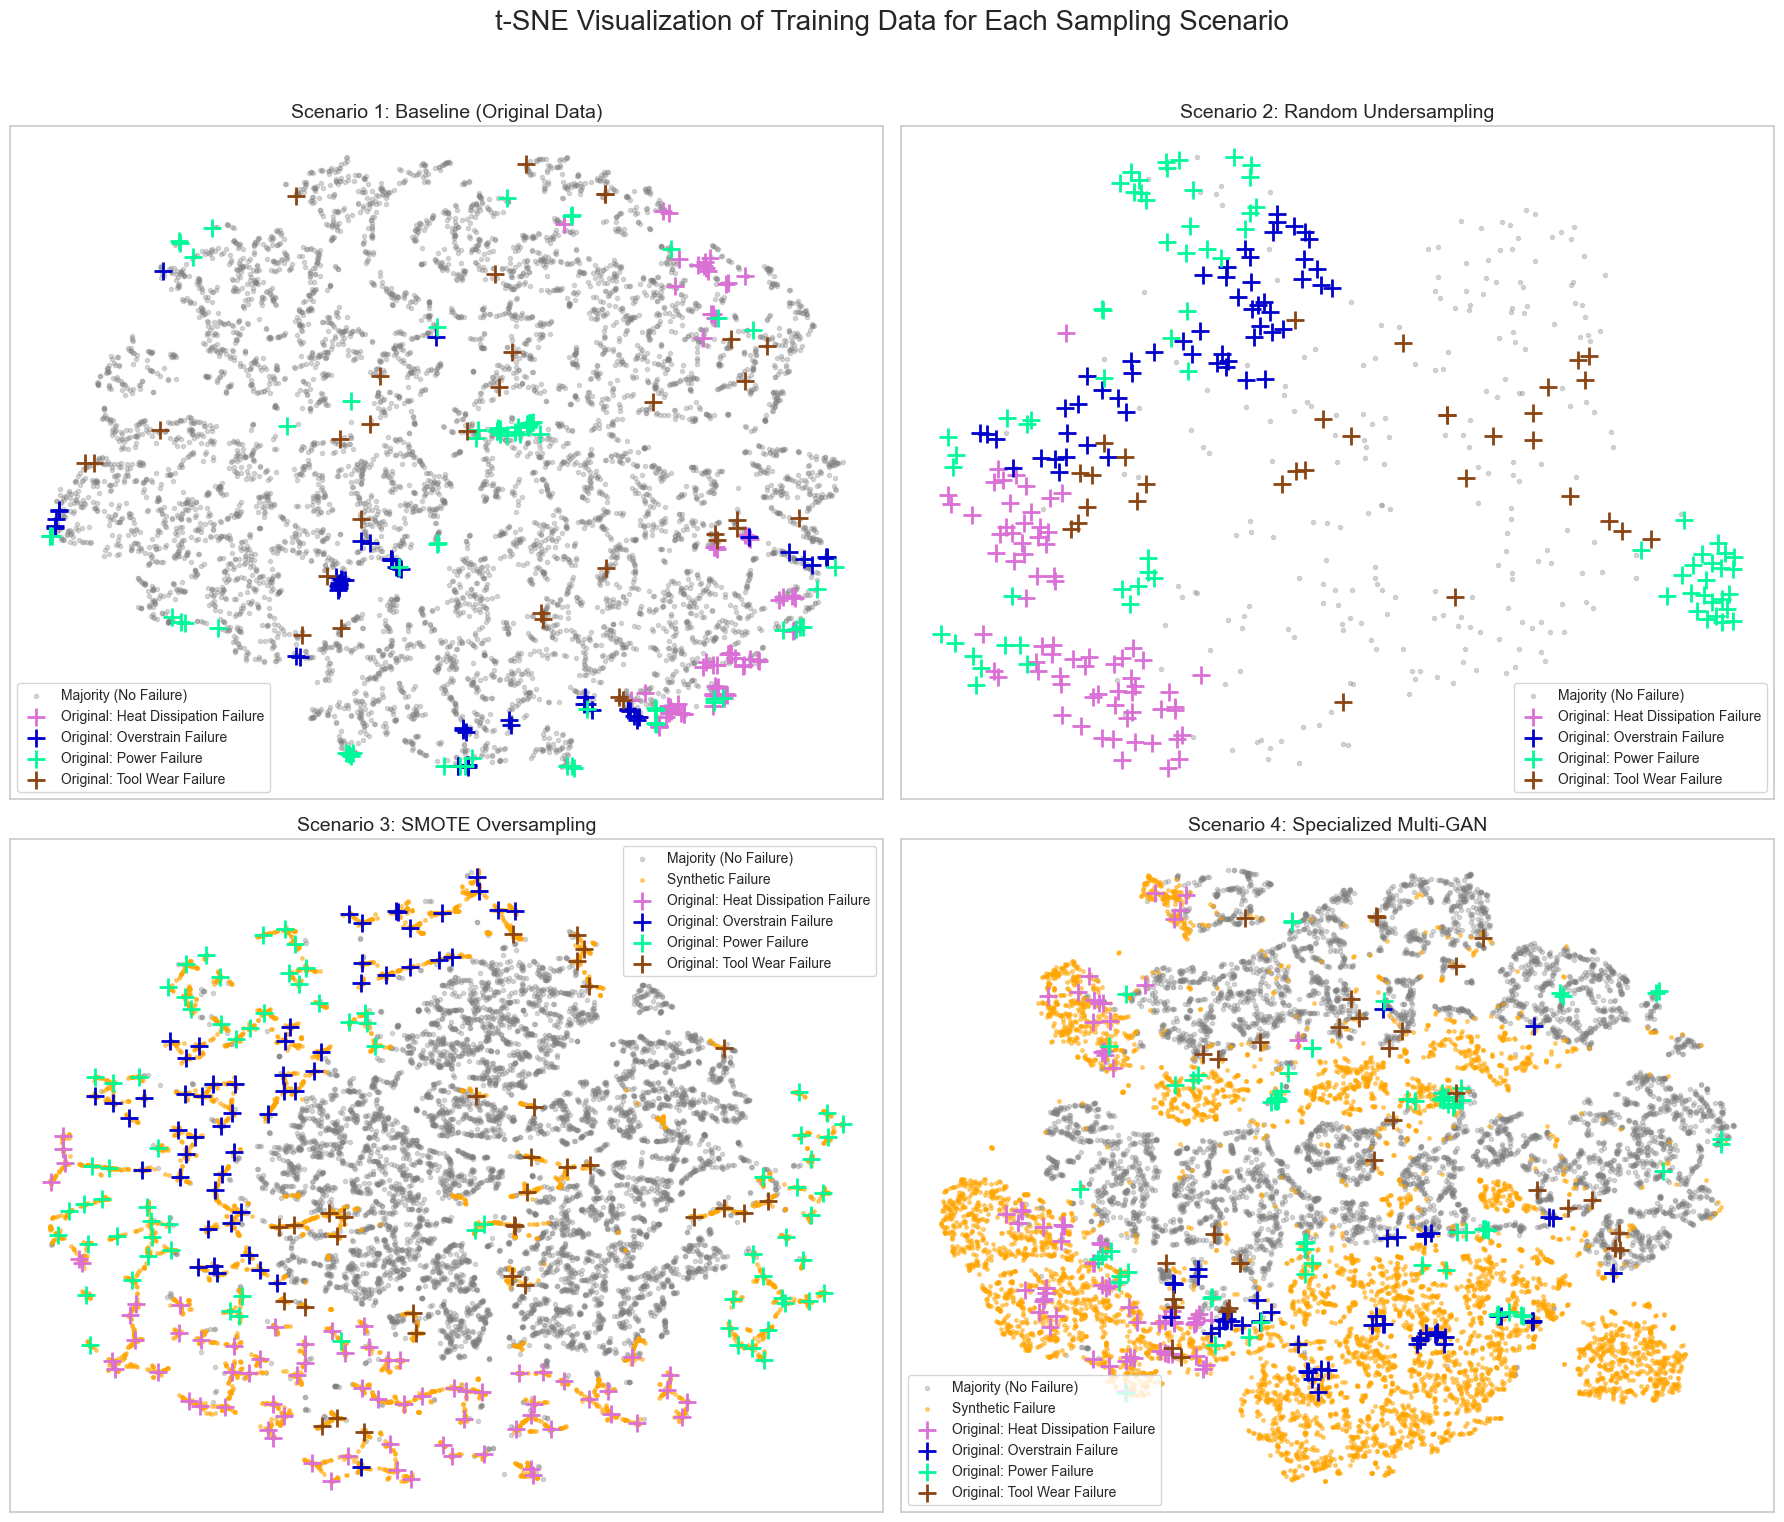

78036

In [60]:
# --- Import necessary library for dimensionality reduction ---
from sklearn.manifold import TSNE
import gc # Garbage Collector

print("Preparing data for visualization...")

# --- 1. Data Preparation (with corrected RUS logic) ---
# Define failure types and a color palette for consistent plotting
failure_color_map = {
    'Heat Dissipation Failure': 'Orchid' # Orchid 
    ,
    'Overstrain Failure': 'MediumBlue' # MediumBlue
    ,
    'Power Failure': 'MediumSpringGreen' # MediumSpringGreen
    ,
    'Tool Wear Failure': 'SaddleBrown' # SaddleBrown 
}

# A. Preprocess the original training data (Baseline)
X_train_model_processed = preprocessor.fit_transform(X_train_model)


# B. Generate data for Random Undersampling (RUS)
rus_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# First, fit the sampler to find out which indices to keep
rus_sampler.fit_resample(X_train_model, y_train)
rus_indices = rus_sampler.sample_indices_
# Use these indices to select the corresponding full rows from X_train and y_train
X_rus_resampled = X_train.iloc[rus_indices]
y_rus_resampled = y_train.iloc[rus_indices]
# Now, the 'FailureType' column in X_rus_resampled is perfectly aligned with y_rus_resampled.
# We can now process the features for the t-SNE plot.
X_rus_resampled_processed = preprocessor.transform(X_rus_resampled.drop('FailureType', axis=1))
# This is the series of failure types, correctly aligned with the resampled data.
rus_failure_types_aligned = X_rus_resampled['FailureType']
# ==========================================================


# C. Generate data for SMOTE Oversampling
smote_sampler = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=N_JOBS)
X_smote_resampled_processed, y_smote_resampled = smote_sampler.fit_resample(X_train_model_processed, y_train)
num_original_samples = len(X_train_model_processed)


# D. Prepare GAN data
num_original_train = X_train_model.shape[0]
if 'X_train_gan_aug' in locals():
    preproc_fitted = grid_search_rf_gan.best_estimator_.named_steps['preprocessor']
    X_train_gan_aug_df = pd.DataFrame(X_train_gan_aug, columns=X_train.columns)
    X_train_gan_aug_processed = preproc_fitted.transform(X_train_gan_aug_df)
    X_gan_original_processed = X_train_gan_aug_processed[:num_original_train, :]
    X_gan_synthetic_processed = X_train_gan_aug_processed[num_original_train:, :]
else: # Handle case where GAN scenario was skipped
    X_train_gan_aug_processed, X_gan_original_processed, X_gan_synthetic_processed = None, None, None


# --- 2. t-SNE Visualization ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto', n_iter=500, n_jobs=-1)
print("Running t-SNE on all scenarios. This may take a few minutes...")

def plot_tsne(ax, X_tsne, y, title, failure_types_series, X_synthetic_tsne=None):
    # Use boolean masks (as numpy arrays) to avoid index label issues
    y_mask_majority = (y == 0)
    y_mask_minority = (y == 1)

    # Plot majority class (non-failures) - zorder=1 (bottom layer)
    ax.scatter(
        X_tsne[y_mask_majority, 0], X_tsne[y_mask_majority, 1],
        c='gray', marker='.', alpha=0.3, label='Majority (No Failure)', zorder=1
    )
    
    # Plot synthetic points if they exist - zorder=2 (middle layer)
    if X_synthetic_tsne is not None and X_synthetic_tsne.shape[0] > 0:
        ax.scatter(
            X_synthetic_tsne[:, 0], X_synthetic_tsne[:, 1],
            c='orange',          
            marker='.',            
            s=25,                  
            alpha=0.5,             
            label='Synthetic Failure',
            zorder=2             
        )

    # Isolate the real minority points
    minority_tsne = X_tsne[y_mask_minority]
    minority_failure_types = failure_types_series[y_mask_minority]

    # Plot original minority class points - zorder=3 (top layer)
    for ft, color in failure_color_map.items():
        ft_mask = (minority_failure_types == ft).values
        if np.any(ft_mask):
            ax.scatter(
                minority_tsne[ft_mask, 0], minority_tsne[ft_mask, 1],
                c=[color], 
                marker='+', 
                s=150,               
                linewidth=2,         
                label=f'Original: {ft}',
                zorder=3               
            )
            
    ax.set_title(title, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='best', fontsize='small')

# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('t-SNE Visualization of Training Data for Each Sampling Scenario', fontsize=20, y=0.95)
axes = axes.flatten()


# --- Plot 1: Baseline ---
print("Visualizing: Baseline")
X_baseline_tsne = tsne.fit_transform(X_train_model_processed)
plot_tsne(axes[0], X_baseline_tsne, y_train.values, 'Scenario 1: Baseline (Original Data)', X_train['FailureType'])

# --- Plot 2: Random Undersampling ---
print("Visualizing: Random Undersampling")
X_rus_tsne = tsne.fit_transform(X_rus_resampled_processed)
plot_tsne(axes[1], X_rus_tsne, y_rus_resampled.values, 'Scenario 2: Random Undersampling', rus_failure_types_aligned)

# --- Plot 3: SMOTE ---
print("Visualizing: SMOTE")
X_smote_tsne_full = tsne.fit_transform(X_smote_resampled_processed)
X_smote_original_tsne = X_smote_tsne_full[:num_original_samples, :]
X_smote_synthetic_tsne = X_smote_tsne_full[num_original_samples:, :]
plot_tsne(axes[2], X_smote_original_tsne, y_train.values, 'Scenario 3: SMOTE Oversampling', X_train['FailureType'], X_synthetic_tsne=X_smote_synthetic_tsne)

# --- Plot 4: GAN ---
print("Visualizing: GAN Oversampling")
if X_train_gan_aug_processed is not None:
    X_gan_tsne_full = tsne.fit_transform(X_train_gan_aug_processed)
    X_gan_original_tsne = X_gan_tsne_full[:num_original_train, :]
    X_gan_synthetic_tsne = X_gan_tsne_full[num_original_train:, :]
    plot_tsne(axes[3], X_gan_original_tsne, y_train.values, 'Scenario 4: Specialized Multi-GAN', X_train['FailureType'], X_synthetic_tsne=X_gan_synthetic_tsne)
else:
    axes[3].text(0.5, 0.5, "GAN Scenario Skipped", horizontalalignment='center', verticalalignment='center', fontsize=14)
    axes[3].set_title("Scenario 4: Specialized Multi-GAN", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Clean up large objects from memory
del X_train_model_processed, X_rus_resampled_processed, X_smote_resampled_processed
if 'X_train_gan_aug_processed' in locals(): del X_train_gan_aug_processed
gc.collect()

## 10. Conclusion



## 11. Notebook Timer Finish

In [61]:
# === Notebook Timer — STOP & REPORT ===
# Print final, explicit report (even if atexit prints one later on shutdown)
_report_total_runtime(prefix="Notebook run")
# If you also want to persist the runtime to a file, uncomment:
# with open("notebook_runtime.log", "a", encoding="utf-8") as f:
#     f.write(f"{NB_START_TS:%Y-%m-%d %H:%M:%S}, {time.perf_counter()-NB_START:.2f} sec\n")
# === /Notebook Timer — STOP & REPORT ===



=== Notebook run runtime ===
Started : 2025-10-05 02:41:41
Elapsed : 14h 5m 9.3s
